In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e5/sample_submission.csv
/kaggle/input/playground-series-s4e5/train.csv
/kaggle/input/playground-series-s4e5/test.csv
/kaggle/input/asymmetricloss-engineering-differentappr-r2-0-88/__results__.html
/kaggle/input/asymmetricloss-engineering-differentappr-r2-0-88/submission.csv
/kaggle/input/asymmetricloss-engineering-differentappr-r2-0-88/__notebook__.ipynb
/kaggle/input/asymmetricloss-engineering-differentappr-r2-0-88/__output__.json
/kaggle/input/asymmetricloss-engineering-differentappr-r2-0-88/custom.css
/kaggle/input/asymmetricloss-engineering-differentappr-r2-0-88/__results___files/__results___67_0.png
/kaggle/input/asymmetricloss-engineering-differentappr-r2-0-88/__results___files/__results___20_0.png
/kaggle/input/asymmetricloss-engineering-differentappr-r2-0-88/__results___files/__results___89_0.png
/kaggle/input/asymmetricloss-engineering-differentappr-r2-0-88/__results___files/__results___215_0.png
/kaggle/input/asymmetricloss-engineering-diffe

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set(style="whitegrid")
from matplotlib.ticker import MaxNLocator,MultipleLocator
import os
import pickle
import scipy.stats
import sklearn.metrics as skm
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.base import clone
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import BayesianRidge, ElasticNetCV, LinearRegression, LassoCV, RidgeCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import statsmodels.formula.api as smf
import warnings
warnings.filterwarnings("ignore")
import xgboost as xgb
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

In [3]:
train = pd.read_csv('/kaggle/input/playground-series-s4e5/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e5/test.csv')

In [4]:
initial_features = [col for col in test.columns if col != 'id']
initial_features1 = [col for col in test.columns if col not in ['id', 'MonsoonIntensity']]

Table of Contents

1. Functions for training and evaluating underestimation and overestimation.
2. EDA.
3. Pre-training model on the basic data. Initial model: XGBR.
4. Plot of underestimation and overestimation. Removal of erroneous data.
5. Removal of erroneous data.
6. Feature engineering 1: Study of the interaction between the entire dataset and a selected subset showing a jump in the target value.
7. Feature importance for the entire dataset.
8. Comparison of permutation and feature importance for the entire dataset and the studied subset of data.
9. Comparison of residuals.
10. Comparison of data distribution.
11. Comparison of correlations.
12. Comparison of interactions of selected features - 3D plots.
13. Comparison of regression results with interaction.
14. Interpolation.
15. Training the XGR model and evaluating the results after feature engineering1.
16. Feature enginering 2. Creating new features (feature interactions) and basic statistics.
17. Training on XGBR model and evaluating results after feature engineering2.
18. Data leakage example.
19. Data splitting into training data and holdout_set.
20. Training other models: Linear, CatBoost, LGBM, Ridge.
21. Evaluating underestimation and overestimation results, holdout_set.
22. Feature engineering 3: MeanTarget encoding on XGB model.
23. Evaluating underestimation and overestimation results, holdout_set.
24. Model optimization: Asymmetric loss function on XGB model.
25. Grid search function using GPU.
26. Training XGB model using gradient and hessian parameters.
27. Evaluating underestimation and overestimation results, holdout_set.
28. Model training results summary - R2 plot.
29. Underestimation and overestimation results summary - plots.
30. Submission.

1. Functions for training and evaluating underestimation and overestimation.

The initial model for feature engineering is XGBR. The model based on gradient decision trees was chosen because it can model complex nonlinear relationships and automatically detect interactions between variables. Data after feature engineering will also be trained on other models. Model evaluation will be reflected by:

1. R2 score which shows what percentage of data variability the model determines.
2. Determination of what percentage of data the model underestimates and overestimates. This is very important because in flood prediction, underestimating risk has worse consequences than overestimating.
3. Predictions on the holdout_set which is 10% of the output data.

In [5]:
r2_avg = {}

In [6]:
end = "\033[0m" ; bold = "\033[1m" ; LightRed = "\033[91m" ; LightBlue = "\033[94m"
BlueBold = LightBlue + bold ; RedBold = LightRed + bold

In [7]:
def cross_validate_regression(model, X, y, label, n_splits=5, random_state=42, single_fold=True, n_repeats=1):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    r2_scores = []
    mae_scores_train = []
    mse_scores_train = []
    mae_scores_test = []
    mse_scores_test = []
    r2_avg[label] = np.full(len(y), np.nan)  

    for fold, (train_index, test_index) in enumerate(kf.split(X)):
    
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        y_pred_test = np.zeros(len(y_test))
        y_pred_train = np.zeros(len(y_train))

        for i in range(n_repeats):
            model_clone = clone(model)
            if hasattr(model_clone, 'random_state'): 
                model_clone.set_params(random_state=random_state + i)
            model_clone.fit(X_train, y_train)
            y_pred_test += model_clone.predict(X_test)
            y_pred_train += model_clone.predict(X_train)

        y_pred_test /= n_repeats
        y_pred_train /= n_repeats

        r2 = r2_score(y_test, y_pred_test)
        mae_train = mean_absolute_error(y_train, y_pred_train)
        mse_train = mean_squared_error(y_train, y_pred_train)
        mae_test = mean_absolute_error(y_test, y_pred_test)
        mse_test = mean_squared_error(y_test, y_pred_test)

        r2_scores.append(r2)
        mae_scores_train.append(mae_train)
        mse_scores_train.append(mse_train)
        mae_scores_test.append(mae_test)
        mse_scores_test.append(mse_test)

        print(f'Fold {fold + 1}: R2 Score = {r2:.5f}, MAE Train = {mae_train:.5f}, MSE Train = {mse_train:.5f}, '
              f'MAE Test = {mae_test:.5f}, MSE Test = {mse_test:.5f}')

        if single_fold:
            break
    avg_r2 = np.mean(r2_scores)
    avg_mae_train = np.mean(mae_scores_train)
    avg_mse_train = np.mean(mse_scores_train)
    avg_mae_test = np.mean(mae_scores_test)
    avg_mse_test = np.mean(mse_scores_test)
    std_r2 = np.std(r2_scores)

    r2_avg[label] = {
        'avg_r2': avg_r2}

    print(f'\n{BlueBold}# Mean R2 Score = {avg_r2:.5f} {RedBold}± {std_r2:.5f} {BlueBold}for {label}{end}')
    print(f'{BlueBold}# Mean MAE Train = {avg_mae_train:.5f}{end}')
    print(f'{BlueBold}# Mean MSE Train = {avg_mse_train:.5f}{end}')
    print(f'{BlueBold}# Mean MAE Test = {avg_mae_test:.5f}{end}')
    print(f'{BlueBold}# Mean MSE Test = {avg_mse_test:.5f}{end}')

    return r2_scores, y_pred_test, y_pred_train, X_test, y_test, X_train, y_train

A function for evaluating a model that determines what percentage of the data is underestimated or overestimated.

In [8]:
overestimation = {}
underestimation = {}

In [9]:
def evaluate_under_over_estimation(X_test, y_test, y_pred_test, label,underestimate_threshold=0.05, overestimate_threshold=-0.05):

    errors = y_test - y_pred_test
    underestimate_indices = errors[errors > underestimate_threshold].index
    overestimate_indices = errors[errors < overestimate_threshold].index
    num_underestimated = len(underestimate_indices)
    num_overestimated = len(overestimate_indices)
    total_samples = len(X_test)
    percent_underestimated = round((num_underestimated / total_samples) * 100, 2)
    percent_overestimated = round((num_overestimated / total_samples) * 100, 2)

    print(f"Model: {label}")
    print(f"Number of underestimated samples: {num_underestimated} ({percent_underestimated:.2f}%)")
    print(f"Number of overestimated samples: {num_overestimated} ({percent_overestimated:.2f}%)")

    underestimation[label] = {
        'num_underestimated': num_underestimated,
        'percent_underestimated': percent_underestimated
    }
    overestimation[label] = {
        'num_overestimated': num_overestimated,
        'percent_overestimated': percent_overestimated
    }
    return underestimation[label], overestimation[label]

2. EDA

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1117957 entries, 0 to 1117956
Data columns (total 22 columns):
 #   Column                           Non-Null Count    Dtype  
---  ------                           --------------    -----  
 0   id                               1117957 non-null  int64  
 1   MonsoonIntensity                 1117957 non-null  int64  
 2   TopographyDrainage               1117957 non-null  int64  
 3   RiverManagement                  1117957 non-null  int64  
 4   Deforestation                    1117957 non-null  int64  
 5   Urbanization                     1117957 non-null  int64  
 6   ClimateChange                    1117957 non-null  int64  
 7   DamsQuality                      1117957 non-null  int64  
 8   Siltation                        1117957 non-null  int64  
 9   AgriculturalPractices            1117957 non-null  int64  
 10  Encroachments                    1117957 non-null  int64  
 11  IneffectiveDisasterPreparedness  1117957 non-null 

In [11]:
train.duplicated().sum()

0

In [12]:
train.drop('id',axis=1).describe().T

,count,mean,std,min,25%,50%,75%,max
MonsoonIntensity,1117957.0,4.921450,2.056387,0.000,3.00,5.000,6.00,16.000
TopographyDrainage,1117957.0,4.926671,2.093879,0.000,3.00,5.000,6.00,18.000
RiverManagement,1117957.0,4.955322,2.072186,0.000,4.00,5.000,6.00,16.000
Deforestation,1117957.0,4.942240,2.051689,0.000,4.00,5.000,6.00,17.000
Urbanization,1117957.0,4.942517,2.083391,0.000,3.00,5.000,6.00,17.000
ClimateChange,1117957.0,4.934093,2.057742,0.000,3.00,5.000,6.00,17.000
DamsQuality,1117957.0,4.955878,2.083063,0.000,4.00,5.000,6.00,16.000
Siltation,1117957.0,4.927791,2.065992,0.000,3.00,5.000,6.00,16.000
AgriculturalPractices,1117957.0,4.942619,2.068545,0.000,3.00,5.000,6.00,16.000
Encroachments,1117957.0,4.949230,2.083324,0.000,4.00,5.000,6.00,18.000


In [13]:
for col in train.columns[1:-1]:
    uniques = ', '.join(map(str, sorted(train[col].unique())))
    print(f'Values in {col:<32}: {uniques:<69}| total={train[col].nunique()}')

Values in MonsoonIntensity                : 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16             | total=17
Values in TopographyDrainage              : 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18     | total=19
Values in RiverManagement                 : 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16             | total=17
Values in Deforestation                   : 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17         | total=18
Values in Urbanization                    : 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17         | total=18
Values in ClimateChange                   : 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17         | total=18
Values in DamsQuality                     : 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16             | total=17
Values in Siltation                       : 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16             | total=17
Values i

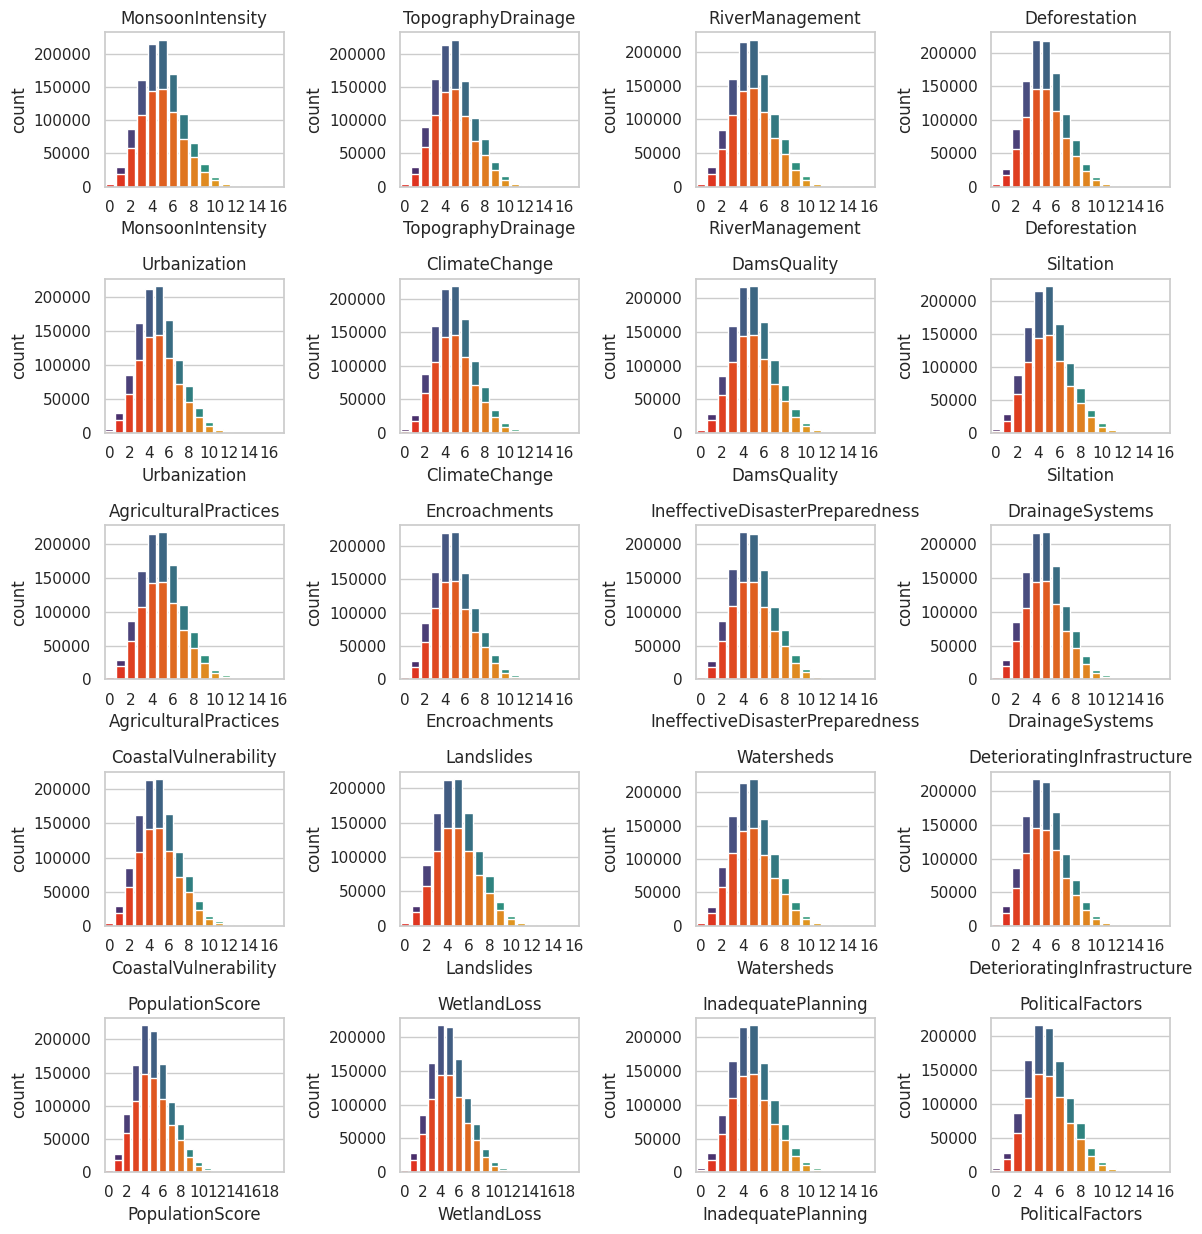

In [14]:
ncol = 4
nrow = int(np.ceil(len(initial_features) / 4))
plt.figure(figsize=(ncol*3, nrow*2.5))
for i,col in enumerate(initial_features):
    ax = plt.subplot(nrow, ncol, i+1)
    sns.countplot(train,x=col,ax=ax,palette='viridis')
    sns.countplot(test,x=col,ax=ax,palette='autumn')
    ax.set_title(col)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.tight_layout();

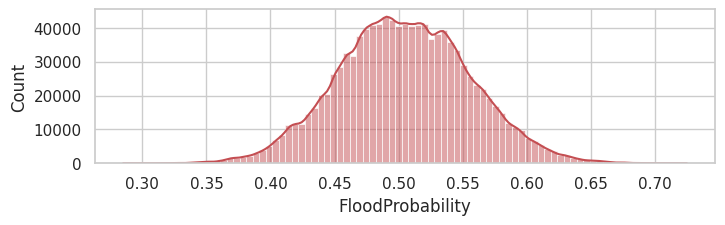

In [15]:
plt.figure(figsize=(8,2))
sns.histplot(train["FloodProbability"], kde=True, \
            bins=np.linspace(train["FloodProbability"].min(), train["FloodProbability"].max(), 88), color='r');
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

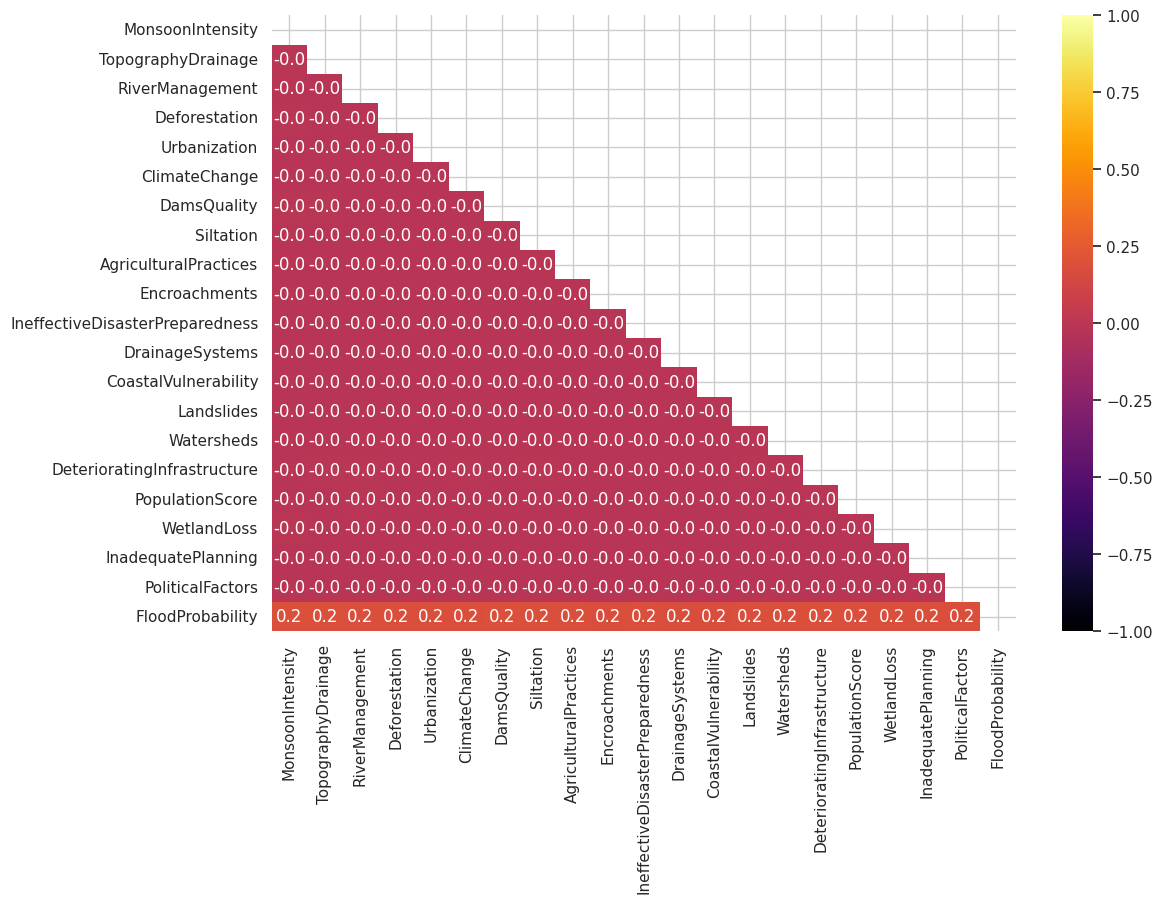

In [16]:
plt.figure(figsize=(12,8))
corr = train.iloc[:,1:].corr()
mask = np.triu(np.ones_like(corr))
sns.heatmap(corr, vmax=1, vmin=-1, center=0, mask=mask, annot=True, fmt='0.1f', cmap='inferno');

In [17]:
pca = PCA()
pca.fit(train[initial_features])
pca.explained_variance_ratio_

array([0.05154727, 0.05151653, 0.05131702, 0.05107014, 0.05102997,
       0.05098338, 0.0508381 , 0.05077164, 0.05069371, 0.05056218,
       0.05051043, 0.0503371 , 0.05025168, 0.05017571, 0.05004197,
       0.04985149, 0.04968824, 0.04946495, 0.04932201, 0.04002649])

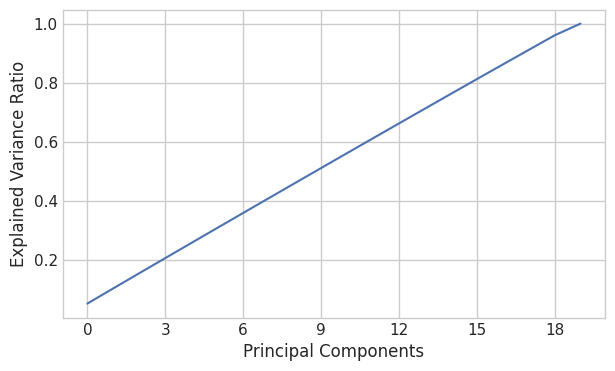

In [18]:
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(7,4))
sns.lineplot(pca.explained_variance_ratio_.cumsum())
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

The same amount of variance for PCA. Dimensionaly reduction with PCA in this case has no point.

Data has outliers. They were not removed so as not to lose information about anomalous factors and flood phenomena.

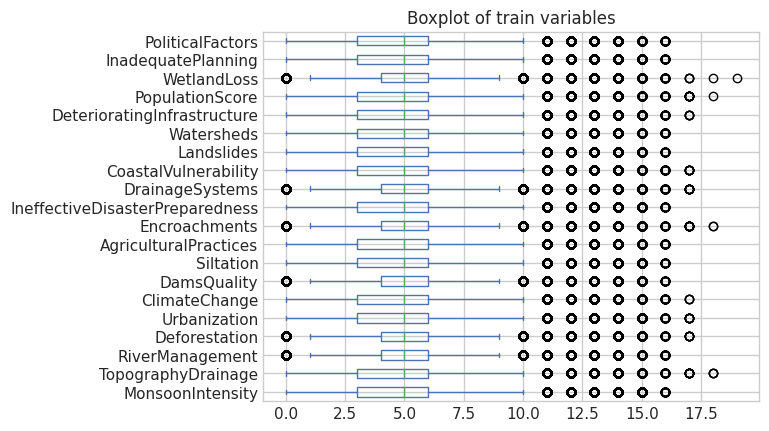

In [19]:
train.drop(['FloodProbability', 'id'], axis=1).plot(kind='box',vert=False)
plt.title('Boxplot of train variables')
plt.show()

3. Pre-training model on the basic data. Initial model: XGBR.

In [20]:
xgbr_model = make_pipeline(RobustScaler(),
                          XGBRegressor())

Original data - one fold

In [21]:
X = train.drop(columns=['id', 'FloodProbability'])
y = train['FloodProbability']

In [22]:
r2_scores, y_pred_test, y_pred_train, X_test, y_test, X_train, y_train = cross_validate_regression(xgbr_model, X, y, 'Original_Data')

Fold 1: R2 Score = 0.80907, MAE Train = 0.01718, MSE Train = 0.00047, MAE Test = 0.01759, MSE Test = 0.00050

# Mean R2 Score = 0.80907 ± 0.00000 for Original_Data
# Mean MAE Train = 0.01718
# Mean MSE Train = 0.00047
# Mean MAE Test = 0.01759
# Mean MSE Test = 0.00050


In [23]:
under1, over1 = evaluate_under_over_estimation(X_test, y_test, y_pred_test, 'Original Data')

Model: Original Data
Number of underestimated samples: 4783 (2.14%)
Number of overestimated samples: 1031 (0.46%)


Conclusion. On data without feature engineering and optimization, the XGBR model is 4 times more likely to underestimate the prediction by 0.05 units. This is not a good result.

4. Presentation of the overestimation and underestimation graph. For the sake of readability of the graph, the unit 0.1 was used.

In [24]:
data = []
for idx, (test_val, pred_val) in enumerate(zip(y_test, y_pred_test)):
    diff = abs(test_val - pred_val)
    if diff > 0.1:
        data.append({'Index': idx, 'y_test': test_val, 'y_pred_test': pred_val, 'Difference': diff})
df = pd.DataFrame(data)

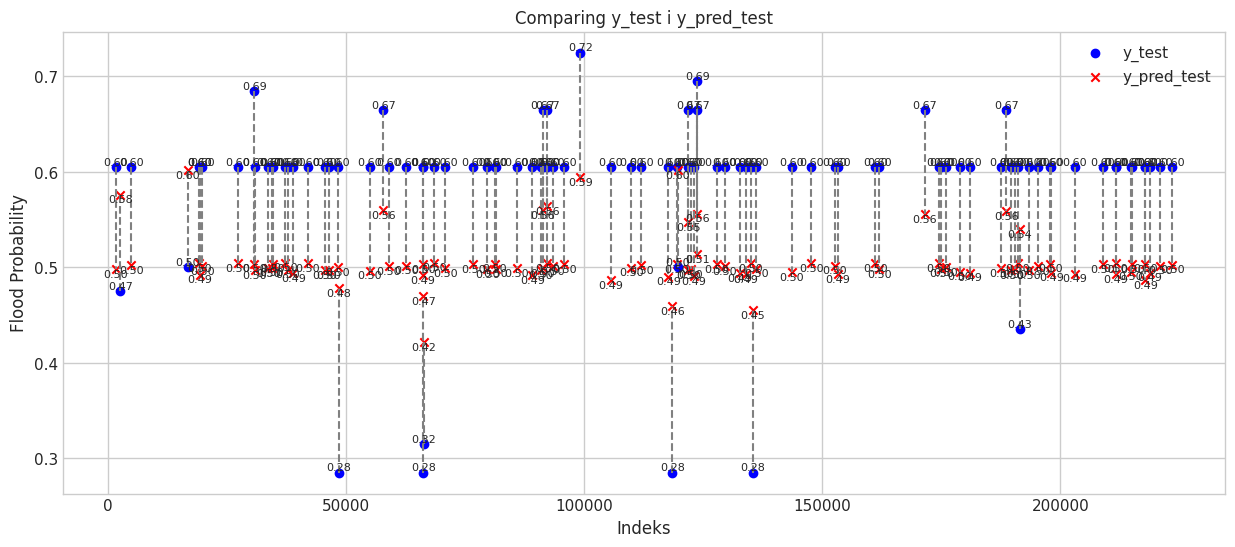

In [25]:
plt.figure(figsize=(15, 6))

for index, row in df.iterrows():
    plt.scatter(row['Index'], row['y_test'], marker='o', color='blue') 
    plt.text(row['Index'], row['y_test'], f"{row['y_test']:.2f}", fontsize=8, va='bottom', ha='center') 

    plt.scatter(row['Index'], row['y_pred_test'], marker='x', color='red')
    plt.text(row['Index'], row['y_pred_test'], f"{row['y_pred_test']:.2f}", fontsize=8, va='top', ha='center')
    plt.plot([row['Index'], row['Index']], [row['y_test'], row['y_pred_test']], color='gray', linestyle='--') 

plt.xlabel('Indeks')
plt.ylabel('Flood Probability')
plt.title('Comparing y_test i y_pred_test')

plt.scatter([], [], marker='o', color='blue', label='y_test')
plt.scatter([], [], marker='x', color='red', label='y_pred_test')
plt.legend() 

plt.show()

Conclusion. The model very often underestimates the results by 0.1 units in the range of flood probability values ​​0.5 - 0.6. This may be because most of the data is in this range and the model adjusts to most of the data. The data distribution is skewed and less data is in the higher ranges of feature values ​​and higher flood probabilities. In terms of flood risk prediction, overestimation is a better option than underestimation. The data requires analysis of features, interactions and the model requires optimization.

5. Removing invalid data. The data for training the model was generated artificially by AI, so it may contain artifacts.

Removing erroneous data: no rain. Flood probability is conditioned by the occurrence of precipitation. The remaining 19 factors can have maximum values, but when the rainfall intensity is zero, the flood probability is also zero. Selecting and removing rows where monsoon rainfall is zero and flood probability is greater than zero. 5431 rows were removed as obvious data errors.

In [26]:
no_rain = train[(train['FloodProbability'] > 0) & (train['MonsoonIntensity'] == 0)]
no_rain.shape

(5431, 22)

In [27]:
train = train[~train.index.isin(no_rain.index)]

6. Feature engineering 1. Study of the interaction between the entire data set and a selected subset showing a jump in the target value.

Lets plot the sum of all features along the column axis to the Traget

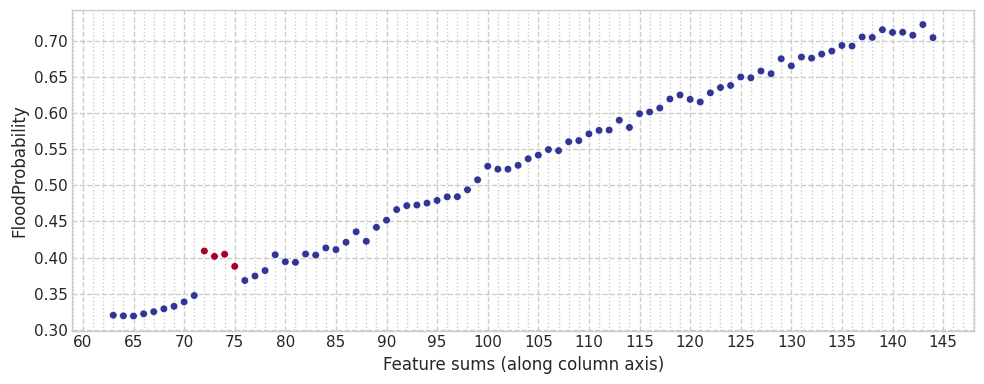

In [28]:
temp = train['FloodProbability'].groupby(train[initial_features].sum(axis=1)).mean()
plt.figure(figsize=(10,4))
sns.scatterplot(x=temp.index, y=temp, c=temp.index.isin(np.arange(72,76)), s=30, cmap='RdYlBu_r')
plt.gca().xaxis.set_major_locator(MultipleLocator(5))
plt.gca().xaxis.set_minor_locator(MultipleLocator(1))
plt.gca().yaxis.set_major_locator(MultipleLocator(0.05))
plt.grid(True, which='major', linestyle='--')
plt.grid(True, which='minor', linestyle=':')
plt.xlabel('Feature sums (along column axis)')
plt.tight_layout()

Conclusion. There is a sudden fluctuation in the mean flood probability in the range of 72-75 sums and also several small fluctuations in other values of the sums. This requires further analysis and examination of this subset of data. The sudden jump in flood probability may be caused by:

a). Nonlinear relationships between factors: Even if the individual factors have the same distributions, means and variances (as indicated by PCA), it does not necessarily mean that their combined effect on the flood probability is linear. Even if each variable individually appears to be evenly distributed, interactions between them can lead to step effects. There may be nonlinear interactions between factors that cause sudden changes in flood probability for certain ranges of the sum. It is necessary to investigate whether interactions occur and, if so, which features interact with each other and cause the sudden increase in probability. Interactions between variables can be difficult to capture with a simple sum of factors. There may be certain combinations of values that have a greater (or smaller) impact on the flood probability than others. If for certain values the sum of some variables is dominated by specific combinations of other variables, this can lead to sudden increases or decreases in the flood probability.

b). Anomalies. Outliers were not removed because this can lead to loss of information and lower prediction results.

c). Data errors. According to the description, this data is artificially generated by AI. So artifacts are possible.

The analysis of the subset of data and an attempt to explain the causes of sudden jumps will be done in the following steps:

a) Study feature importance. Use a decision tree model that better examines nonlinear relationships and determines interactions between variables. b) Select data with sudden jumps c) Compare permutations on the full dataset and the subset of interest. d) Compare feature importance on the full dataset and the subset of interest e) Compare residuals, checking the data for anomalies f) Compare feature distributions in the original dataset and the subset of interest g) Compare factor correlations and flood probabilities in both subsets i) Visualize and compare interactions between variables in 3D graphs in the or oiginal dataset and the subset of interest. j) Apply a linear regression model with interactions to both datasets.

7. Feature Importance for all data

In [29]:
xgbr_model.fit(X_train, y_train)

Pipeline(steps=[('robustscaler', RobustScaler()),
                ('xgbregressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

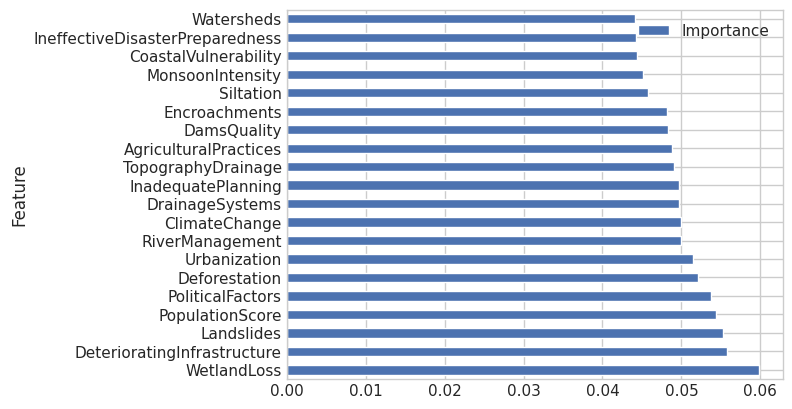

In [30]:
importance = xgbr_model.named_steps['xgbregressor'].feature_importances_
feature_names = X.columns
feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
feature_importance.plot(kind='barh', x='Feature', y='Importance')
plt.show()

Conclusion. All factors have similar feature import values. Low feature importance variability may indicate that the model is based on subtle interactions between multiple features, rather than on single, strong variables. In the interaction studies, the dependence of the DeterioratingInfrastructure factor will be used because it shows the greatest importance.

Isolate a subset of the data for testing. This is data in the range of 72-75 sums, which shows a spike in FloodProbability. The subset under test has 9337 rows.

In [31]:
def get_indices_for_flood_probability_range(df, id_col, flood_col, range_start, range_end):
    df = df.drop(columns=[id_col])
    row_sums = df.drop(columns=[flood_col]).sum(axis=1)
    temp1 = df[flood_col].groupby(row_sums).mean()
    values_in_range = temp1[(temp1.index >= range_start) & (temp1.index <= range_end)]
    indices = df.index[df.drop(columns=[flood_col]).sum(axis=1).isin(values_in_range.index)]
    return indices

In [32]:
indices = get_indices_for_flood_probability_range(df=train, id_col='id', flood_col='FloodProbability', range_start=72, range_end=75)
print(indices)

Index([      4,     103,     137,     188,     193,     249,     397,     429,
           993,    1164,
       ...
       1116607, 1116674, 1116716, 1116831, 1117193, 1117353, 1117399, 1117599,
       1117724, 1117802],
      dtype='int64', length=9337)


In [33]:
range72_75_indices = train.index.intersection(indices)
range72_75 = train.loc[range72_75_indices]
range72_75.shape

(9337, 22)

8. Comparison of permutation and feature importance for the entire dataset and a subset of the data under consideration.

Permutations involve randomly shuffling the variables and recalculating the results of the model fit measures R2 to assess whether the observed relationships are statistically significant or may be due to random noise. Examining the permutations on the original data set and on the subset of interest clarifies whether the significantly higher probability of flooding in the 72-75 sum range is due to true interactions between factors or is a random effect or noise in the data.

If the original R² in the sum range (72-75) is significantly larger than the R² values ​​after permutation, it means that there is a specific relationship between variables in this range and interactions between variables influence the jump in flood probability.

R² for permutations: For permutations, we look at how the model handles shuffled data. If the R² of the shuffled data is significantly lower than the original, it means that there are significant dependencies in the data that are not random.

In [34]:
def permutation(df, x_vars, y_var, num_permutacji=50, sum_range=None):
    if sum_range:
        df = df[(df[x_vars].sum(axis=1) >= sum_range[0]) & (df[x_vars].sum(axis=1) <= sum_range[1])]
    X = df[x_vars]
    y = df[y_var]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    model = xgb.XGBRegressor()
    model.fit(X_scaled, y)
    y_pred = model.predict(X_scaled)
    r2_original = r2_score(y, y_pred)

    feature_importances = model.feature_importances_
    r2_permutacje = []

    for i in range(num_permutacji):
        X_permuted = X.apply(np.random.permutation) 
        X_permuted_scaled = scaler.transform(X_permuted) 
        model.fit(X_permuted_scaled, y)
        y_pred_permuted = model.predict(X_permuted_scaled)
        r2_permuted = r2_score(y, y_pred_permuted)
        r2_permutacje.append(r2_permuted)

    return r2_original, r2_permutacje, feature_importances

In [35]:
r2_original_all_data, r2_permutacje_all_data, feature_importances_all_data = permutation(train, initial_features, 'FloodProbability')

In [36]:
print(f"R^2 oryginalne: {r2_original_all_data}")
print(f"R^2 z permutacji: {r2_permutacje_all_data}")

R^2 oryginalne: 0.8182796853965488
R^2 z permutacji: [0.012146479322611481, 0.012652062964482513, 0.012075768422061373, 0.012036185605610705, 0.012789825792580811, 0.011556963419563693, 0.012324923864634019, 0.01199109162746681, 0.012468576820705013, 0.011958701679292583, 0.01240424832771203, 0.012613068880040545, 0.011979643182922106, 0.01256856071587431, 0.012026110870073548, 0.012779266579848958, 0.012453196721231574, 0.013084221612226665, 0.01248845531121201, 0.011790002870858518, 0.01136743326557521, 0.01241554891139296, 0.012819038414502826, 0.011354877803041341, 0.012057669194986631, 0.012729393155821889, 0.012499972088391376, 0.012038573354859472, 0.012243047038384192, 0.012527665574686764, 0.01262604261849598, 0.011934201658504562, 0.012420931962888182, 0.012127492462174039, 0.011845801518016397, 0.012613319468171236, 0.011940354022146216, 0.012308645931779827, 0.011451836450032005, 0.011796107120167099, 0.012010928674126009, 0.012333564966933386, 0.011683603067781378, 0.01213

In [37]:
print(f"feature_importances_original: {feature_importances_all_data}")

feature_importances_original: [0.05235834 0.05342172 0.04464788 0.05338824 0.05217723 0.0451928
 0.04818287 0.04814431 0.04258629 0.04920844 0.04829823 0.04761988
 0.05398823 0.0533502  0.04973442 0.05336912 0.05561083 0.04775222
 0.04632255 0.05464621]


In [38]:
r2_original_range, r2_permutacje_range, feature_importances_range = permutation(range72_75, initial_features,'FloodProbability', sum_range=None)

In [39]:
print(f"R^2 oryginalne: {r2_original_range}")
print(f"R^2 z permutacji: {r2_permutacje_range}")

R^2 oryginalne: 0.6705233649621043
R^2 z permutacji: [0.5976663913233026, 0.5927391829080078, 0.5894358249006235, 0.584042065991613, 0.5935829412687039, 0.564894313291589, 0.6131920459808753, 0.603861486618714, 0.6055128439699166, 0.6042561338266716, 0.5823755636615733, 0.5930597587427631, 0.5879990852991237, 0.594840655202133, 0.5868626993437309, 0.5826669468051224, 0.6019637997136672, 0.5443062109477539, 0.5737452264886493, 0.5940973674532657, 0.5968701230636964, 0.5727280844163207, 0.6056142537530056, 0.5944956183324452, 0.5848742577124643, 0.6058696460816162, 0.6091463101236747, 0.5860764666678329, 0.5889811790104634, 0.5795337431147913, 0.5692790191697352, 0.5944005545056397, 0.5989735485478735, 0.5711143383498705, 0.5849035874265236, 0.5806544193903058, 0.5762809754560413, 0.5952741694212932, 0.5607341622116566, 0.5925917224627659, 0.591170443965879, 0.5843767504685213, 0.5819542370772091, 0.5651945745793219, 0.570935554247753, 0.5904125023740958, 0.5869574297331146, 0.5806044872

In [40]:
print(f"feature_importances_range: {feature_importances_range}")

feature_importances_range: [0.04057795 0.04572355 0.05143321 0.05006782 0.04887366 0.05342682
 0.0531527  0.05204702 0.04650025 0.05077766 0.05254628 0.05114369
 0.05048953 0.05084819 0.05261141 0.05240264 0.05454884 0.04385435
 0.04624557 0.05272881]


R² for original data: Shows how well the model explains the relationship between variables and flood probability. R² for permutation: Shows how well the model fits the shuffled data, which could be due to chance.

Comparison chart: Allows you to visually recognize whether the original data is significantly different from the permuted data.

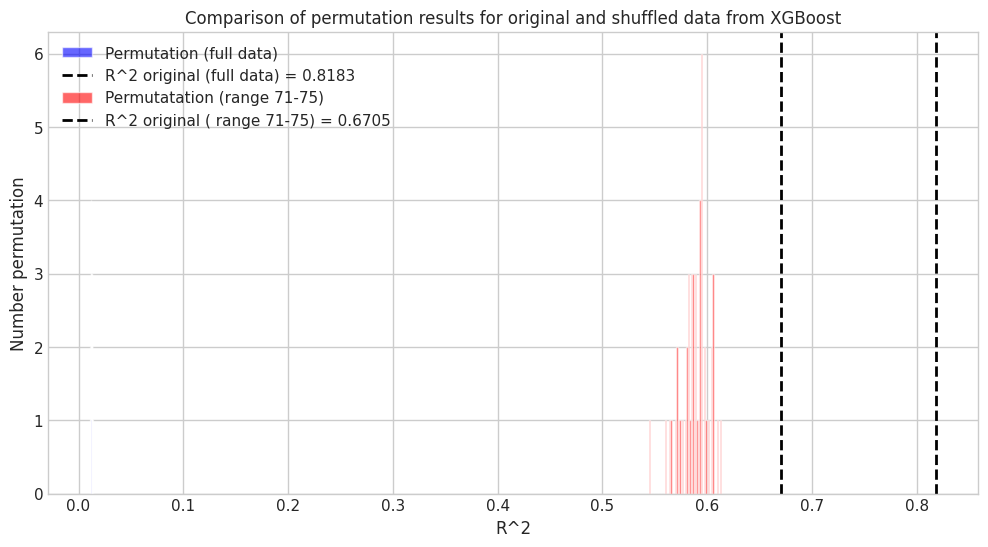

In [41]:
plt.figure(figsize=(12, 6))
plt.hist(r2_permutacje_all_data, bins=50, alpha=0.6, label='Permutation (full data)', color='blue')
plt.axvline(r2_original_all_data, color='black', linestyle='dashed', linewidth=2, label=f'R^2 original (full data) = {r2_original_all_data:.4f}')
plt.hist(r2_permutacje_range, bins=50, alpha=0.6, label='Permutatation (range 71-75)', color='red')
plt.axvline(r2_original_range, color='black', linestyle='dashed', linewidth=2, label=f'R^2 original ( range 71-75) = {r2_original_range:.4f}')
plt.legend()
plt.xlabel('R^2')
plt.ylabel('Number permutation')
plt.title('Comparison of permutation results for original and shuffled data from XGBoost')
plt.show()

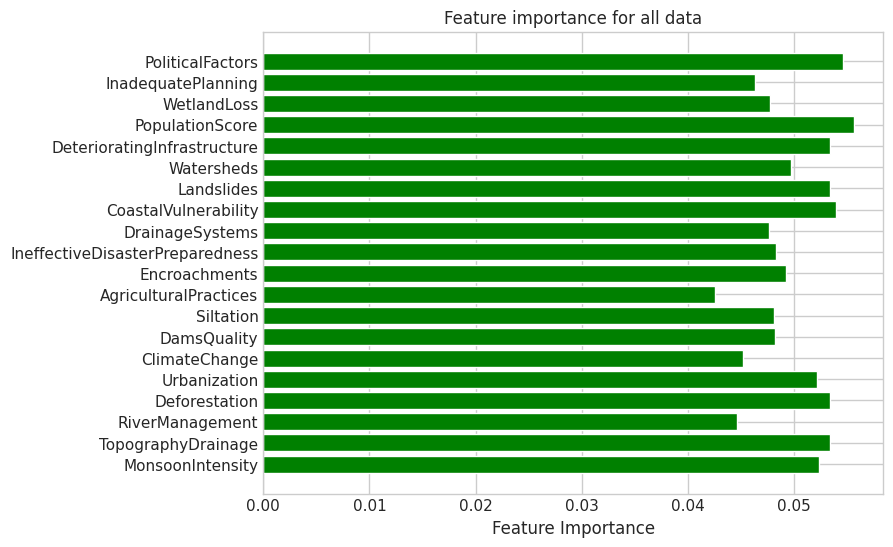

In [42]:
plt.figure(figsize=(8, 6))
plt.barh(initial_features, feature_importances_all_data, color='green')
plt.xlabel('Feature Importance')
plt.title('Feature importance for all data')
plt.show()

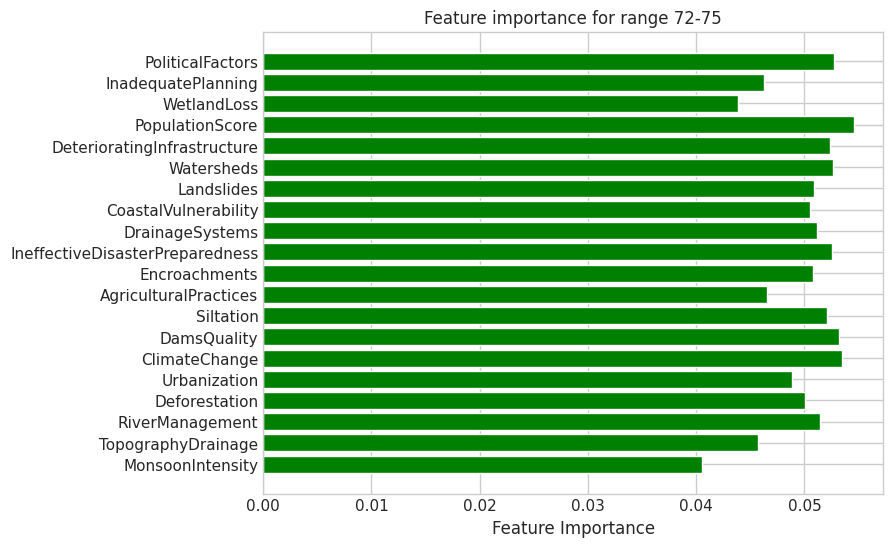

In [43]:
plt.figure(figsize=(8, 6))
plt.barh(initial_features, feature_importances_range, color='green')
plt.xlabel('Feature Importance')
plt.title('Feature importance for range 72-75')
plt.show()

Conclusion. For the whole data set: R2 from permutation around 0.01 suggests that the model after permutation practically loses its ability to explain the variability in the data. This means that the dependencies between features in the whole data set are crucial for high prediction of flood probability. R2 from permutation for the studied subset range 72-75 - R2 0.6 is close to R2 before permutation 0.67 which indicates that interactions between features are not crucial. R2 before permutation for the studied subset 0.67 is lower than R2 before permutation for the whole set 0.81. This indicates that in the studied subset there may be noises destabilizing the model.

Comparison of residuals.

In [44]:
residuals = y_train - y_pred_train

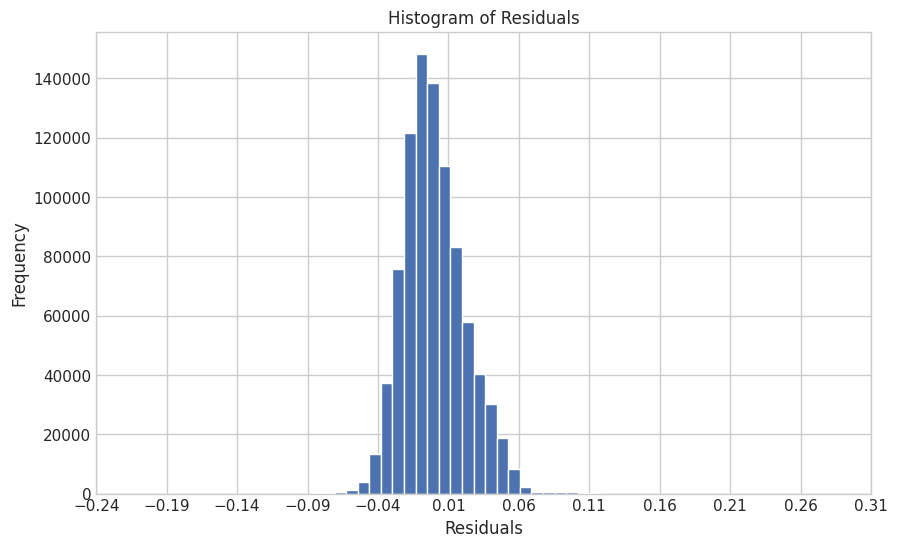

In [45]:
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=50)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
start = round(min(residuals) - 0.05, 2)  
end = round(max(residuals) + 0.05, 2)    
plt.xticks(np.arange(start, end + 0.05, 0.05))
plt.show()

In [46]:
if not isinstance(residuals, pd.Series):
    residuals = pd.Series(residuals)
common_indices = residuals.index.intersection(indices)
df_common = residuals.loc[common_indices]

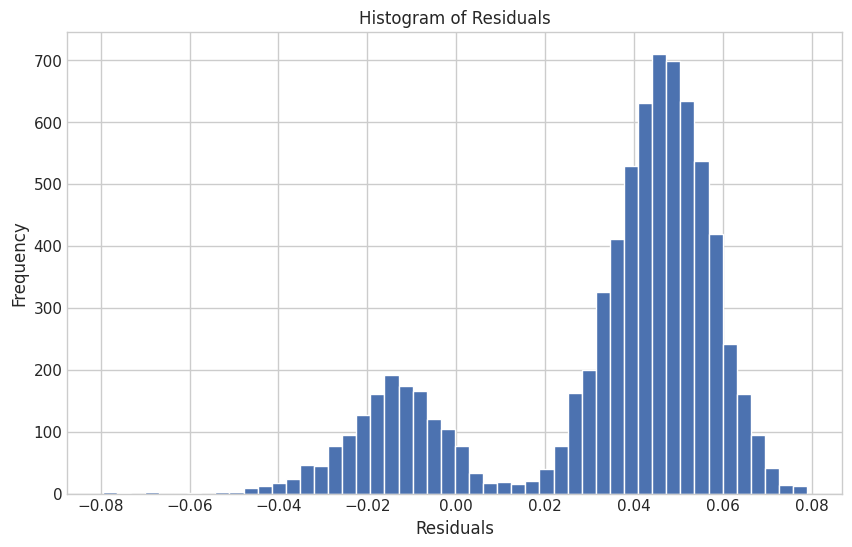

In [47]:
plt.figure(figsize=(10, 6))
plt.hist(df_common, bins=50)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

Conclusion: The data from the subset with sums 72-75 are very much residuals

10. Comparison of data distribution.

a) Distribution of the entire data

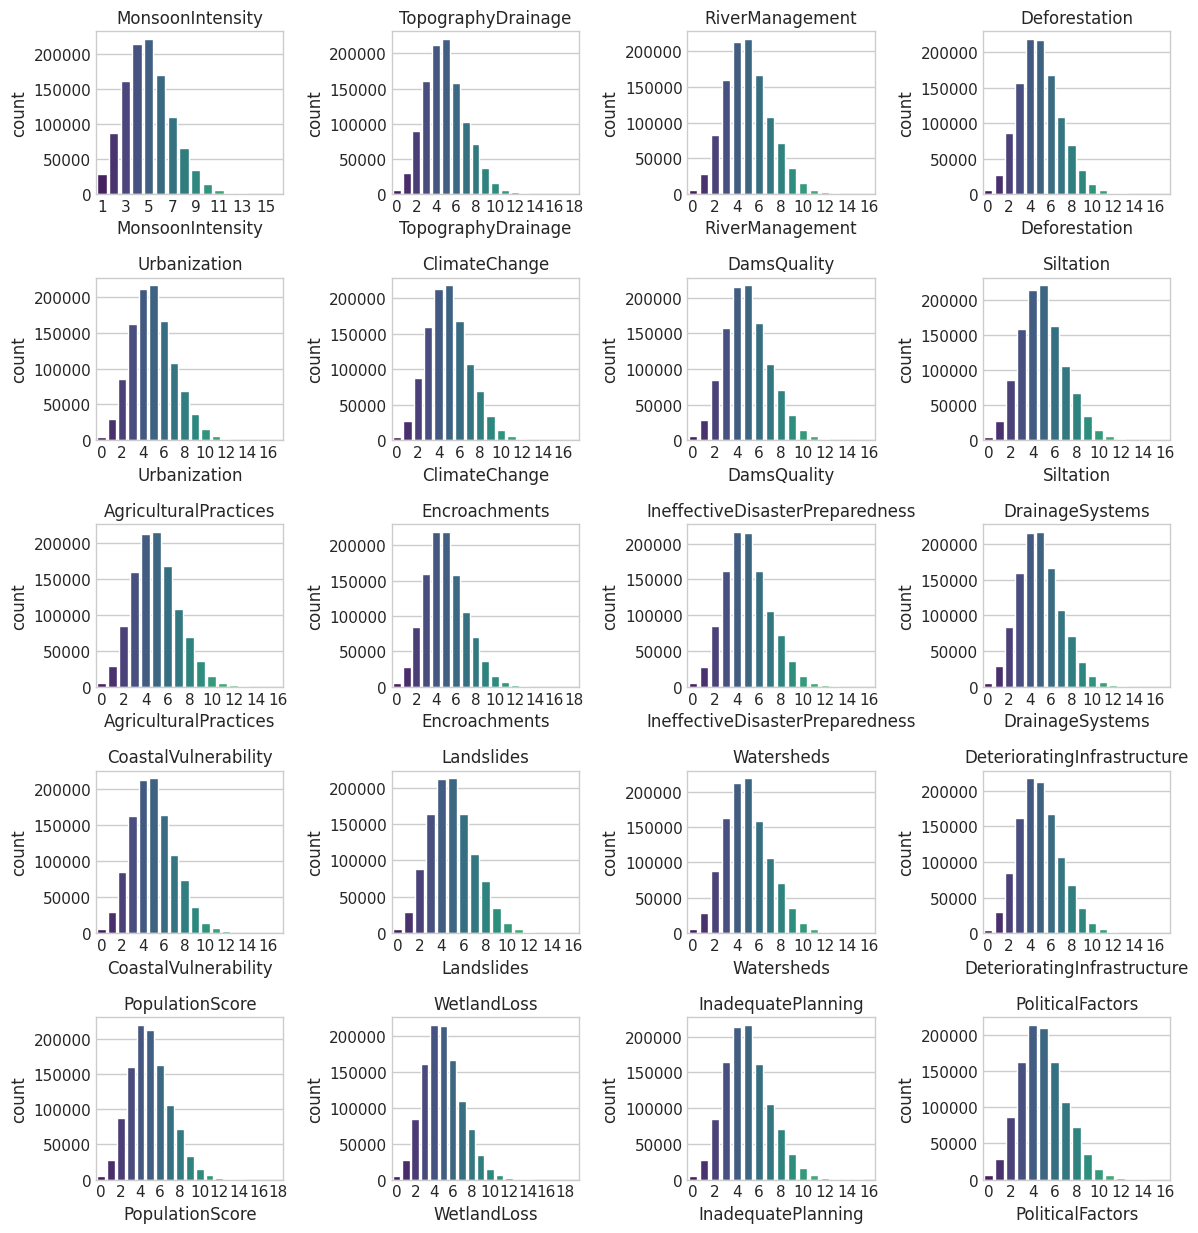

In [48]:
ncol = 4
nrow = int(np.ceil(len(initial_features) / 4))
plt.figure(figsize=(ncol*3, nrow*2.5))
for i,col in enumerate(initial_features):
    ax = plt.subplot(nrow, ncol, i+1)
    sns.countplot(train,x=col,ax=ax,palette='viridis')
    ax.set_title(col)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.tight_layout();

b) Distribution of the tested subset

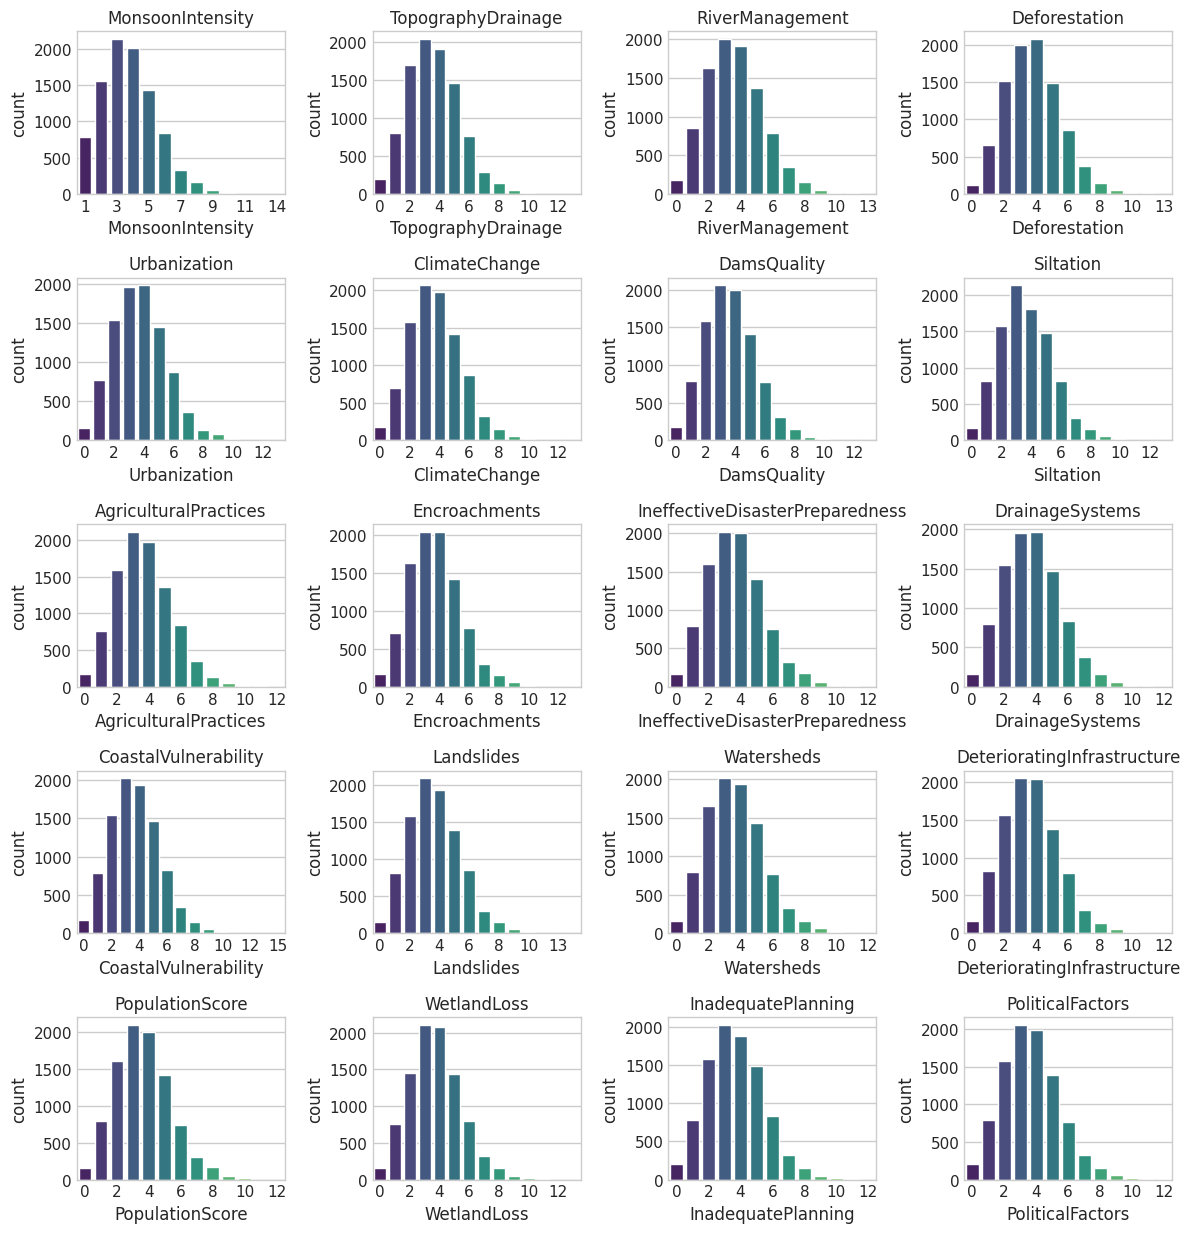

In [49]:
ncol = 4
nrow = int(np.ceil(len(initial_features) / 4))
plt.figure(figsize=(ncol*3, nrow*2.5))
for i,col in enumerate(initial_features):
    ax = plt.subplot(nrow, ncol, i+1)
    sns.countplot(range72_75,x=col,ax=ax,palette='viridis')
    ax.set_title(col)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.tight_layout();

Conclusion: The distribution of data in the range of sums 72-75 does not differ from the distribution of the entire data. It is also slightly positive. With a higher flood probability, there is no particular pattern of features in the range of sums 72 - 75 that could explain the significant increase in flood probability.

11. Comparison of correlations.

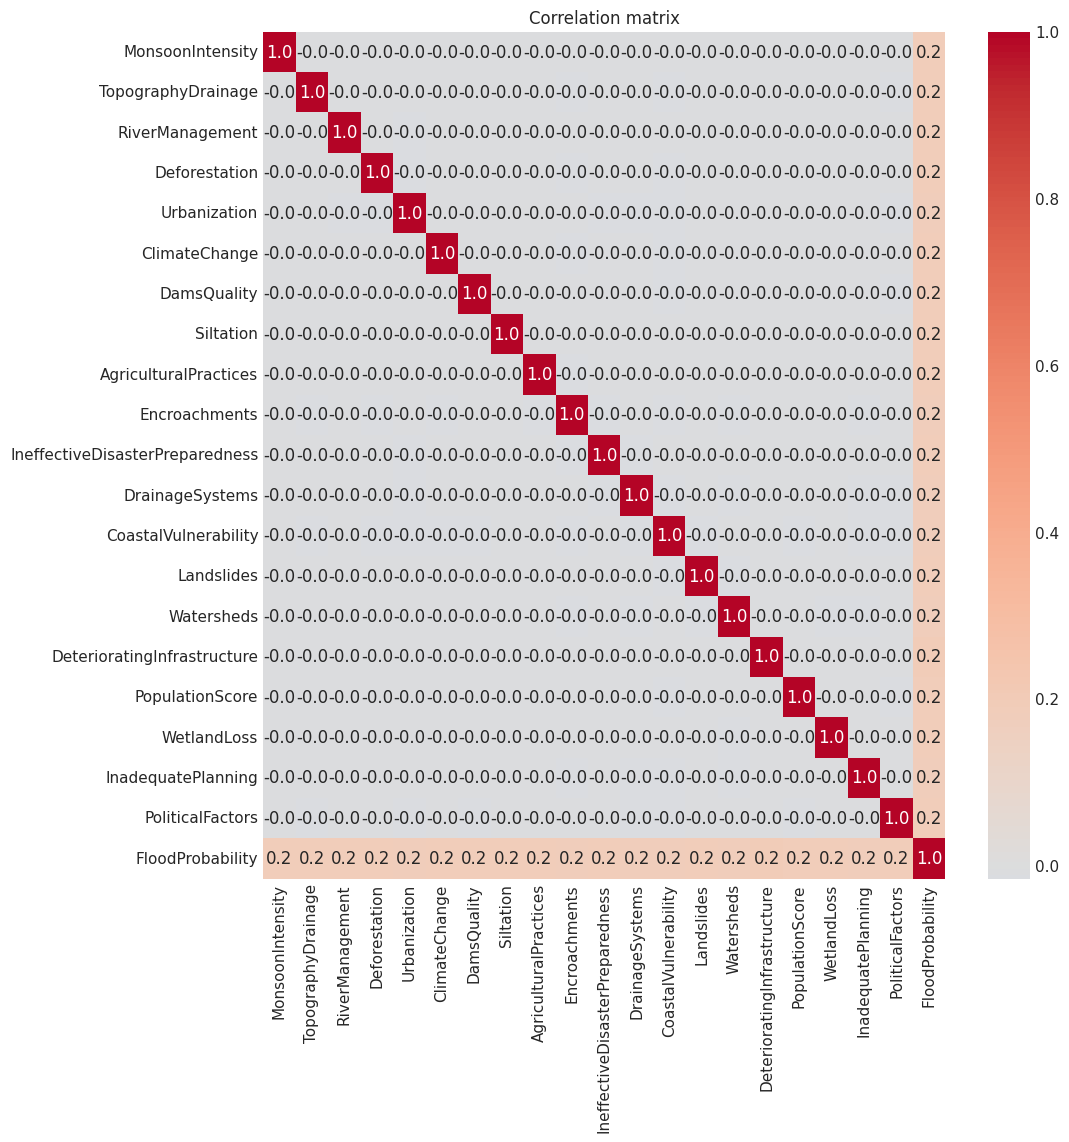

In [50]:
corr_features = initial_features + ['FloodProbability']
cc = np.corrcoef(train[corr_features], rowvar=False)
plt.figure(figsize=(11, 11))
sns.heatmap(cc, center=0, cmap='coolwarm', annot=True, fmt='.1f',
            xticklabels=corr_features, yticklabels=corr_features)
plt.title('Correlation matrix')
plt.show()

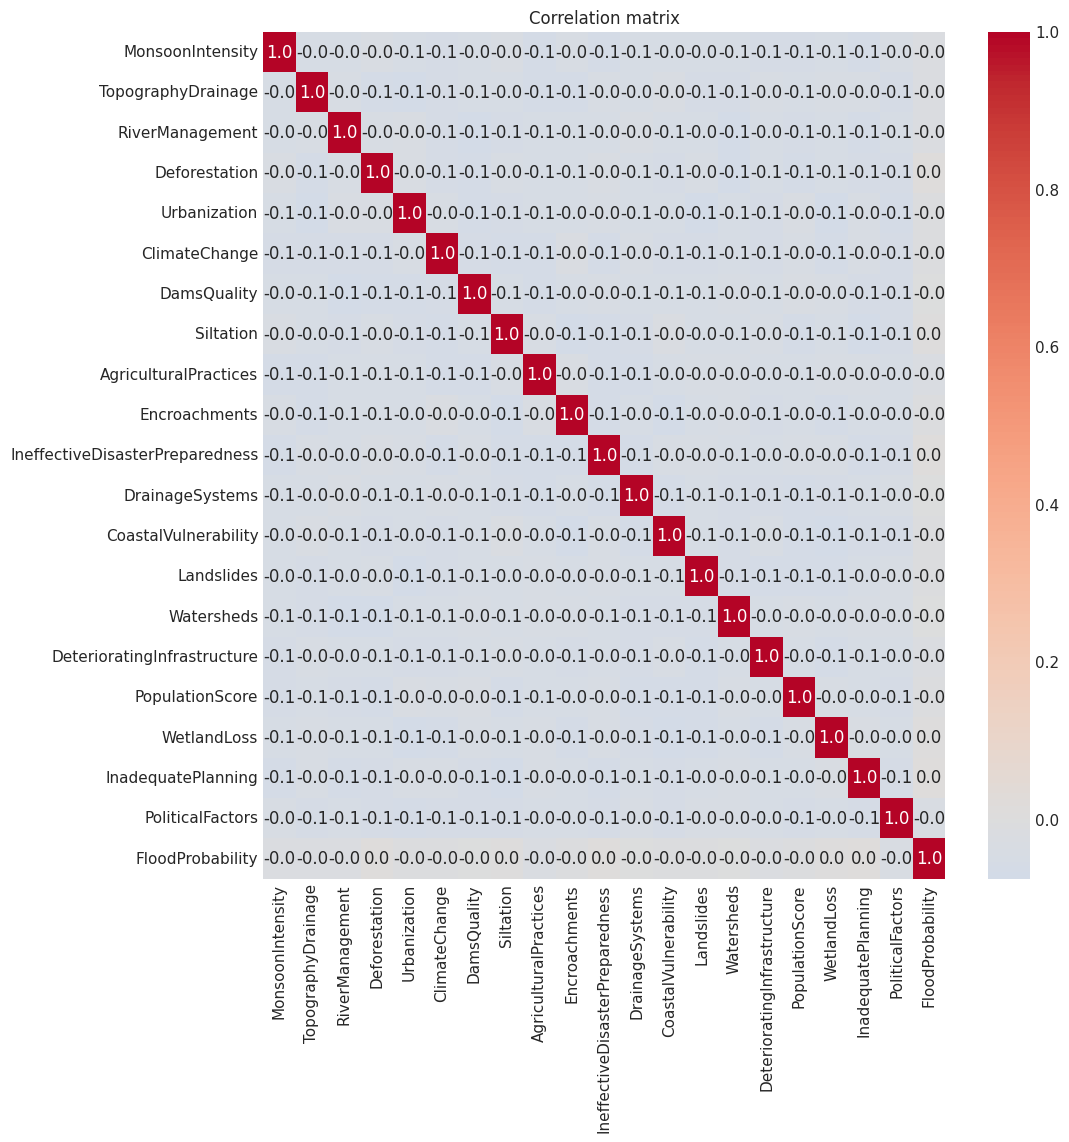

In [51]:
corr_features = initial_features + ['FloodProbability']
cc = np.corrcoef(range72_75[corr_features], rowvar=False)
plt.figure(figsize=(11, 11))
sns.heatmap(cc, center=0, cmap='coolwarm', annot=True, fmt='.1f',
            xticklabels=corr_features, yticklabels=corr_features)
plt.title('Correlation matrix')
plt.show()

Conclusion: In the studied range there is no correlation between features with sums of 72-75 and flood probability. In the entire data set the correlation between each feature and flood probability is 0.2.

12. Visualization of feature interactions - 3D graphs. Checking whether two variables combine in a specific way, influencing the probability of flooding in 3D space

In [52]:
def plot_two_3d_charts(train, range72_75, a, b):
    fig = plt.figure(figsize=(14, 6))

    ax1 = fig.add_subplot(121, projection='3d')
    scatter1 = ax1.scatter(train[a], train[b], train['FloodProbability'],
                           c=train['FloodProbability'], cmap='coolwarm')
    ax1.set_xlabel(a, labelpad=10)
    ax1.set_ylabel(b, labelpad=10)
    ax1.set_zlabel('Flood Probability', labelpad=10)
    ax1.set_title(f'All_data: {a} vs {b}', pad=20)

    ax2 = fig.add_subplot(122, projection='3d')
    scatter2 = ax2.scatter(range72_75[a], range72_75[b], range72_75['FloodProbability'],
                           c=range72_75['FloodProbability'], cmap='coolwarm')
    ax2.set_xlabel(a, labelpad=10)
    ax2.set_ylabel(b, labelpad=10)
    ax2.set_zlabel('Flood Probability', labelpad=10)
    ax2.set_title(f'Range 72_75: {a} vs {b}', pad=20)

    cbar = fig.colorbar(scatter1, ax=[ax1, ax2], location='top', shrink=0.4, pad=0.15)
    cbar.set_label('Flood Probability')

    plt.subplots_adjust(left=0.05, right=0.95, top=0.85, bottom=0.05, wspace=0.4)

    plt.show()

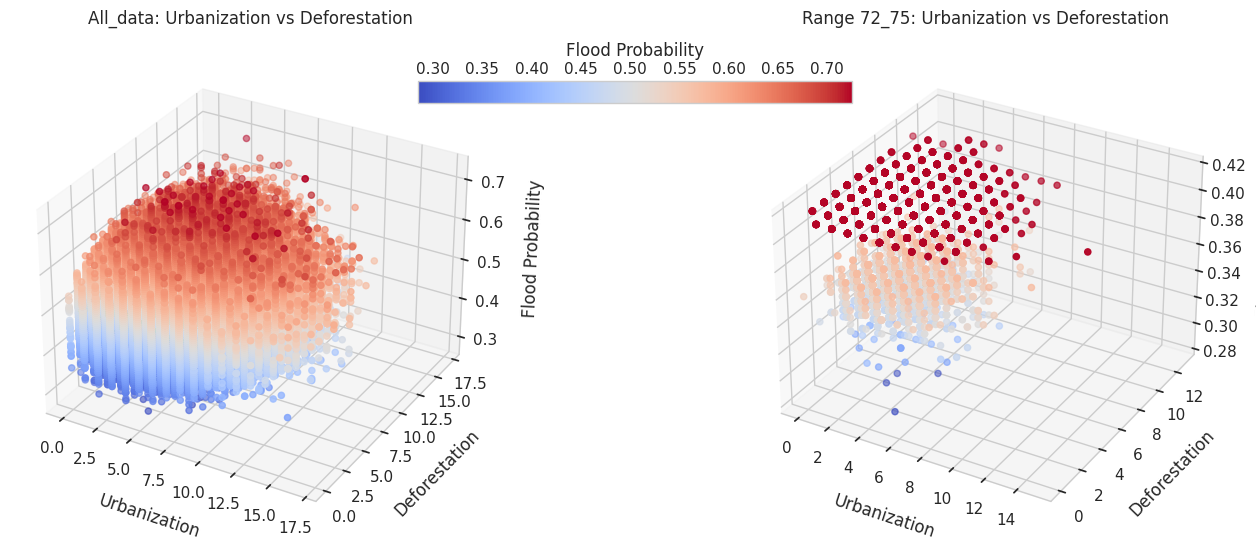

In [53]:
plot_two_3d_charts(train, range72_75, 'Urbanization', 'Deforestation')

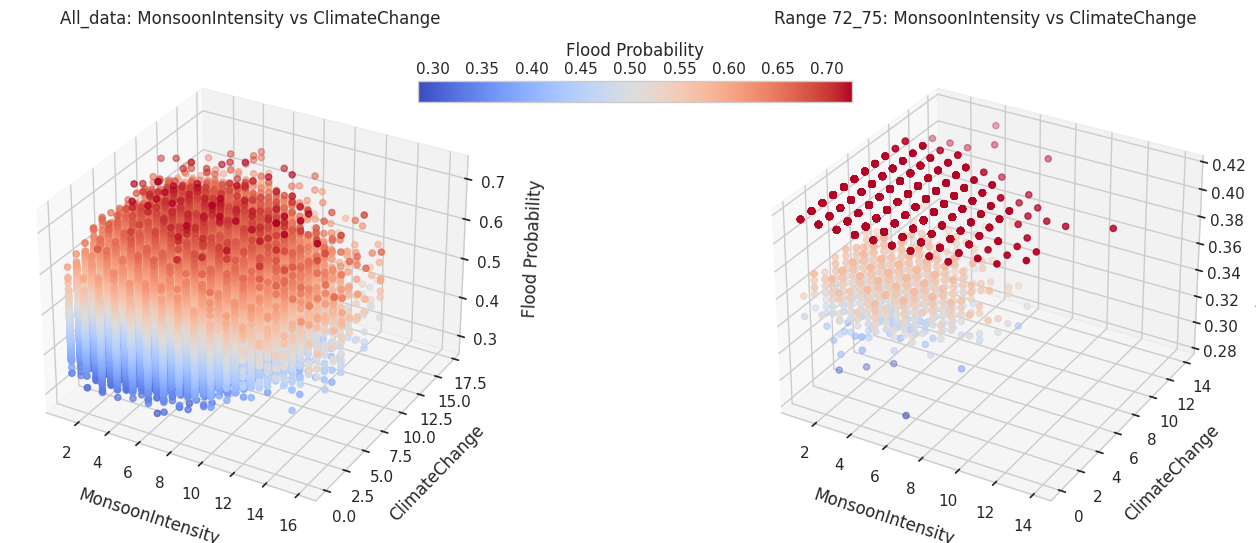

In [54]:
plot_two_3d_charts(train, range72_75, 'MonsoonIntensity', 'ClimateChange')

Conclusion. Analysis of the interaction of two factors on the probability of flooding shows that there are interactions between factors in the entire data set. In the studied subset of data there are flat surfaces on the 3D graph, which indicates the lack of interaction of factors.

13. Comparing the results of statistical tests for interactions (linear regression with interactions). Creating a linear regression model that includes interactions between variables. Such interactions in regression mean that the effect of one variable on the outcome depends on the value of another variable.

In [55]:
formula = 'FloodProbability ~ MonsoonIntensity * PopulationScore'
model = smf.ols(formula, data=train).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       FloodProbability   R-squared:                       0.070
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                 2.789e+04
Date:                Sun, 27 Apr 2025   Prob (F-statistic):               0.00
Time:                        17:05:54   Log-Likelihood:             1.7726e+06
No. Observations:             1112526   AIC:                        -3.545e+06
Df Residuals:                 1112522   BIC:                        -3.545e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

In [56]:
formula = 'FloodProbability ~ MonsoonIntensity * PopulationScore'
model = smf.ols(formula, data=range72_75).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       FloodProbability   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.7716
Date:                Sun, 27 Apr 2025   Prob (F-statistic):              0.510
Time:                        17:05:54   Log-Likelihood:                 21613.
No. Observations:                9337   AIC:                        -4.322e+04
Df Residuals:                    9333   BIC:                        -4.319e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

Conclusion: Based on the visual analysis of the 3D interactions and also on the regression calculations with interaction, it can be determined that the data labeled range71_75 are noise that disturbs the stability of the model. The negative coefficient for the interaction for the set with the sum of range 71-75 indicates that when both factors (monsoon intensity and climate change) increase simultaneously, their joint influence is slightly smaller than the sum of their individual influences. This means that there is a small damping effect: increasing both variables leads to a slightly smaller increase in the probability of flooding than expected. These data can lead to very unfavorable underestimations of the probability of flooding.

Based on the above analyses, it can be concluded that there is no basis for assessing that the sudden jump in dependencies is the result of interactions of specific features. There is no basis for creating a new feature based on this jump in the range of sums 72-75. The data in the rows with sums in the range 72 - 75 are not special. There are no special interactions there. Additionally, with a high probability, it is an error in the data generated artificially by AI, which may disrupt the stability of the model.

In order not to lose information, this data will not be deleted, but the flood probability values ​​will be interpolated based on neighboring values.

14. Interpolation.

Interpolating flood probability values can help smooth the data and make the model more stable without removing important observations.

In [57]:
train['artifakt'] = train.index.isin(indices).astype(int)

In [58]:
train['artifakt'] = train.index.isin(indices).astype(int)
train.loc[train['artifakt'] == 1, 'FloodProbability'] = np.nan
train['sum'] = train[initial_features].sum(axis=1)
mask = train['sum'].isin([71, 76])
srednia_flood_probability = train.loc[mask, 'FloodProbability'].mean()
train['FloodProbability'] = train['FloodProbability'].fillna(srednia_flood_probability)

In [59]:
train= train.drop(columns=['sum', 'artifakt'])

In [60]:
X = train.drop(columns=['id', 'FloodProbability'])
y = train['FloodProbability']

In [61]:
r2_scores, y_pred_test, y_pred_train, X_test, y_test, X_train, y_train = cross_validate_regression(xgbr_model, X, y, 'XGBR_Without_one_artifakt')

Fold 1: R2 Score = 0.81939, MAE Train = 0.01683, MSE Train = 0.00046, MAE Test = 0.01728, MSE Test = 0.00048

# Mean R2 Score = 0.81939 ± 0.00000 for XGBR_Without_one_artifakt0.27
# Mean MAE Train = 0.016830.27
# Mean MSE Train = 0.000460.27
# Mean MAE Test = 0.017280.27
# Mean MSE Test = 0.000480.27


In [62]:
under2, over2 = evaluate_under_over_estimation(X_test, y_test, y_pred_test, 'XGBR_without_one_artifakt')

Model: XGBR_without_one_artifakt
Number of underestimated samples: 4438 (1.99%)
Number of overestimated samples: 960 (0.43%)


Finding and interpolating further artifacts

In [63]:
def get_indices_for_flood_probability_range(df, id_col, flood_col):
    df = df.drop(columns=[id_col])
    row_sums = df.drop(columns=[flood_col]).sum(axis=1)
    temp1 = df[flood_col].groupby(row_sums).mean()
    sum_values = list(range(72, 75)) + [79, 88, 100, 114, 121, 130, 144]
    values_in_range = temp1[temp1.index.isin(sum_values)]
    indices = df.index[df.drop(columns=[flood_col]).sum(axis=1).isin(values_in_range.index)]

    return indices

In [64]:
indices = get_indices_for_flood_probability_range(df=train, id_col='id', flood_col='FloodProbability')

In [65]:
indices.shape

(73217,)

In [66]:
train['artifakt'] = train.index.isin(indices).astype(int)

In [67]:
artefakt = train[train['artifakt'] == 1]

In [68]:
artefakt.loc[:, 'sum'] = artefakt[initial_features].astype(int).sum(axis=1)

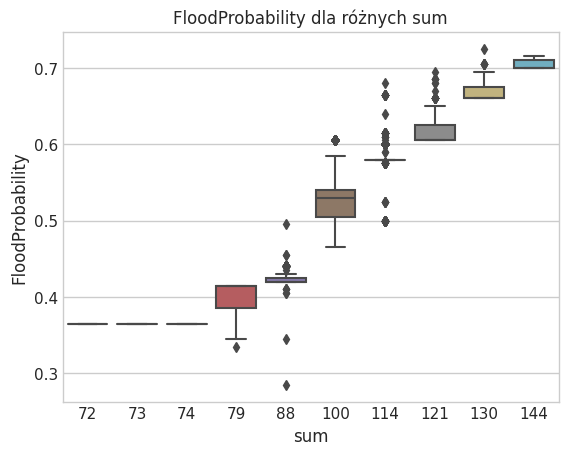

In [69]:
sns.boxplot(x=artefakt['sum'], y=train['FloodProbability'])
plt.title('FloodProbability dla różnych sum')
plt.show()

In [70]:
train.loc[train['artifakt'] == 1, 'FloodProbability'] = np.nan
train['sum'] = train[initial_features].sum(axis=1)
range_sums = list(range(72, 76))  
specific_sums = [79, 88, 100, 114, 121, 130, 144] 
adjacent_sums = [(val - 1, val + 1) for val in range_sums + specific_sums]
for sum_pair in adjacent_sums:
    lower_sum, upper_sum = sum_pair
    mask_lower = train['sum'] == lower_sum
    mask_upper = train['sum'] == upper_sum
    avg_flood_prob = train.loc[mask_lower | mask_upper, 'FloodProbability'].mean()
    target_mask = train['sum'].isin([lower_sum + 1, upper_sum - 1])
    train.loc[target_mask & train['FloodProbability'].isna(), 'FloodProbability'] = avg_flood_prob

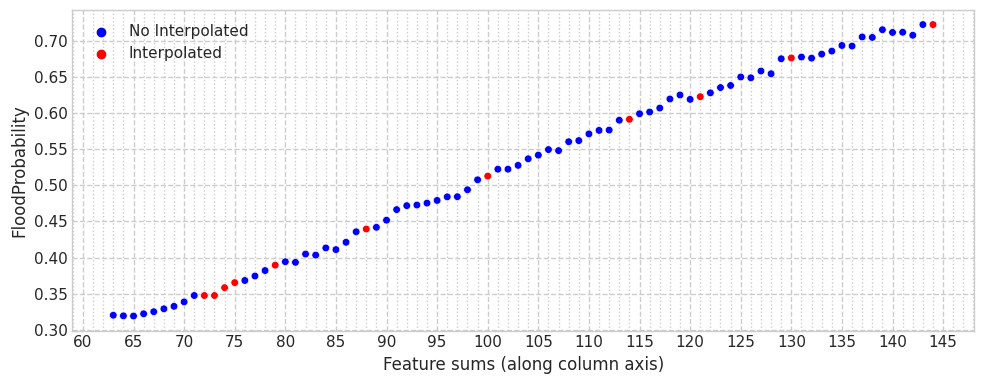

In [71]:
temp = train['FloodProbability'].groupby(train[initial_features].sum(axis=1)).mean()
highlight_sums = list(range(72, 76)) + [79, 88, 100, 114, 121, 130, 144]
temp_labels = temp.index.isin(highlight_sums)
labels = ['Interpolated' if label else 'No Interpolated' for label in temp_labels]
plt.figure(figsize=(10, 4))
sns.scatterplot(x=temp.index,
                y=temp,
                hue=labels, 
                palette={'Interpolated': 'red', 'No Interpolated': 'blue'},  
                s=30)
plt.gca().xaxis.set_major_locator(MultipleLocator(5))
plt.gca().xaxis.set_minor_locator(MultipleLocator(1))
plt.gca().yaxis.set_major_locator(MultipleLocator(0.05))
plt.grid(True, which='major', linestyle='--')
plt.grid(True, which='minor', linestyle=':')
plt.xlabel('Feature sums (along column axis)')
plt.tight_layout()
plt.show()

In [72]:
train= train.drop(columns=['sum', 'artifakt'])

15. Training the XGBR model and evaluating the results after feature engineering 1.

In [73]:
X = train.drop(columns=['id', 'FloodProbability'])
y = train['FloodProbability']

In [74]:
r2_scores, y_pred_test, y_pred_train, X_test, y_test, X_train, y_train = cross_validate_regression(xgbr_model, X, y, 'XGBR_Without_all_artifakts')

Fold 1: R2 Score = 0.83480, MAE Train = 0.01596, MSE Train = 0.00042, MAE Test = 0.01635, MSE Test = 0.00044

# Mean R2 Score = 0.83480 ± 0.00000 for XGBR_Without_all_artifakts0.27
# Mean MAE Train = 0.015960.27
# Mean MSE Train = 0.000420.27
# Mean MAE Test = 0.016350.27
# Mean MSE Test = 0.000440.27


In [75]:
under3, over3 = evaluate_under_over_estimation(X_test, y_test, y_pred_test, 'XGBR_Without_all_artifakts')

Model: XGBR_Without_all_artifakts
Number of underestimated samples: 4110 (1.85%)
Number of overestimated samples: 838 (0.38%)


Conclusions: Removing errors from the data improves the prediction and slightly the ratio of underestimated and overestimated results.

16. Feature engineering 2. Creating new features (columns) in a dataset to improve the performance of predictive models.

Scaling: RobustScaler based on median as central measure was used because the data has outliers and a slightly skewed distribution. The skew is towards lower values ​​and this can cause lower predictions. RobustScaler can eliminate this effect. Logarithmic and boxcox transformations did not improve the results.

a) Multiplication. Exploring feature interactions: Using features created from interactions (e.g. multiplying two features or using a combination) can improve the model.

The data contains information about rainfall intensity in the MonsoonIntensity column and the remaining 19 factors that affect the size of the flood. If the rainfall intensity is low, then regardless of the values ​​of the remaining 19 factors, the probability of flooding will also be low. Let's multiply the sum of the 19 factors of each row by the value in the MonsoonIntensity column.

In [76]:
train['Multiplication'] = train[initial_features1].sum(axis=1) * train['MonsoonIntensity']
test['Multiplication'] = test[initial_features1].sum(axis=1) * test['MonsoonIntensity']

In [77]:
X = train.drop(columns=['id', 'FloodProbability'])
y = train['FloodProbability']

In [78]:
r2_scores, y_pred_test, y_pred_train, X_test, y_test, X_train, y_train = cross_validate_regression(xgbr_model, X, y, ' XGBR_Multiplication')

Fold 1: R2 Score = 0.87387, MAE Train = 0.01381, MSE Train = 0.00032, MAE Test = 0.01404, MSE Test = 0.00034

# Mean R2 Score = 0.87387 ± 0.00000 for  XGBR_Multiplication0.27
# Mean MAE Train = 0.013810.27
# Mean MSE Train = 0.000320.27
# Mean MAE Test = 0.014040.27
# Mean MSE Test = 0.000340.27


b) Sum. Boolean Variable (Indicator Variables): Creating a binary variable that indicates whether a given value meets certain conditions. Such variables can be more easily manipulated because decision trees are naturally oriented towards binary partitions.

It is logical that flooding is more likely when the sum of factors exceeds a certain threshold, e.g. 100. The xgr model is a model based on gradient decision trees and such a binary variable causes the model to receive a simplified index and can more efficiently create splits in trees. Let's create a new column (with the value 1 if the sum of factors is greater than 100 and 0 if it is smaller). This column can help the model to discover key relationships in the data faster.

In [79]:
train['sum'] = train[initial_features].sum(axis=1)
train['sum100'] = train['sum'].apply(lambda x: 1 if x >= 100 else 0)
test['sum'] = test[initial_features].sum(axis=1)
test['sum100'] = test['sum'].apply(lambda x: 1 if x >= 100 else 0)

In [80]:
X = train.drop(columns=['id', 'FloodProbability'])
y = train['FloodProbability']

In [81]:
r2_scores, y_pred_test, y_pred_train, X_test, y_test, X_train, y_train = cross_validate_regression(xgbr_model, X, y, ' XGBR_Multiplication_Sum')

Fold 1: R2 Score = 0.88073, MAE Train = 0.01334, MSE Train = 0.00031, MAE Test = 0.01348, MSE Test = 0.00032

# Mean R2 Score = 0.88073 ± 0.00000 for  XGBR_Multiplication_Sum0.27
# Mean MAE Train = 0.013340.27
# Mean MSE Train = 0.000310.27
# Mean MAE Test = 0.013480.27
# Mean MSE Test = 0.000320.27


c) Statistics. Creating new variables by summing, averaging, minimizing, or maximizing values.

In [82]:
def calculate_statistics(df, columns):
    df['median'] = df[columns].median(axis=1)
    df['std'] = df[columns].std(axis=1)
    df['mean'] = df[columns].mean(axis=1)
    df['var'] = df[columns].var(axis=1)
    df['max'] = df[columns].max(axis=1)
    df['min'] = df[columns].min(axis=1)
    df['skew'] = df[columns].skew(axis=1)
    df['kurt'] = df[columns].kurt(axis=1)

    return df

In [83]:
train = calculate_statistics(train, initial_features)
test = calculate_statistics(test, initial_features)

17. Training on the XGR model and evaluating the results after feature engineering 2.

In [84]:
X = train.drop(columns=['id', 'FloodProbability'])
y = train['FloodProbability']

In [85]:
r2_scores, y_pred_test, y_pred_train, X_test, y_test, X_train, y_train = cross_validate_regression(xgbr_model, X, y, 'XGBR_Multiplication_Sum_Stat')

Fold 1: R2 Score = 0.88188, MAE Train = 0.01322, MSE Train = 0.00031, MAE Test = 0.01338, MSE Test = 0.00031

# Mean R2 Score = 0.88188 ± 0.00000 for XGBR_Multiplication_Sum_Stat0.27
# Mean MAE Train = 0.013220.27
# Mean MSE Train = 0.000310.27
# Mean MAE Test = 0.013380.27
# Mean MSE Test = 0.000310.27


In [86]:
under4, over4 = evaluate_under_over_estimation(X_test, y_test, y_pred_test, 'XGBR_Multiplication_Sum_Stat')

Model: XGBR_Multiplication_Sum_Stat
Number of underestimated samples: 981 (0.44%)
Number of overestimated samples: 399 (0.18%)


Conclusions: The process of transforming and creating new columns improved the prediction performance. However, the model underestimates the data to a greater extent and requires optimization.

18. Data leakage example. Artificially increasing the R2 score by using a target to create new features. In this case, the relationship between monsoon intensity greater than 0.5 and flood prediction was used. A new column called selected_monsun was created. The model performs well, but it is not possible to test it on the holdout_set. A model with R2 - 0.93 will not work on real data because there will be no target value to create a new feature selected_monsun.

In [87]:
train1 = train.copy()
train1['selected_monsun'] = np.where(train1['FloodProbability'] > 0.5, train1['MonsoonIntensity'], 0)

In [88]:
X1 = train1.drop(columns=['id', 'FloodProbability'])
y1 = train1['FloodProbability']

In [89]:
r2_scores, y_pred_test, y_pred_train, X_test, y_test, X_train, y_train = cross_validate_regression(xgbr_model, X1, y1, 'XGBR_Data_leakage')

Fold 1: R2 Score = 0.93723, MAE Train = 0.00917, MSE Train = 0.00016, MAE Test = 0.00926, MSE Test = 0.00017

# Mean R2 Score = 0.93723 ± 0.00000 for XGBR_Data_leakage0.27
# Mean MAE Train = 0.009170.27
# Mean MSE Train = 0.000160.27
# Mean MAE Test = 0.009260.27
# Mean MSE Test = 0.000170.27


In [90]:
under5, over5 = evaluate_under_over_estimation(X_test, y_test, y_pred_test, 'XGBR_Data_leakage')

Model: XGBR_Data_leakage
Number of underestimated samples: 812 (0.36%)
Number of overestimated samples: 223 (0.10%)


Conclusion: Cannot use such a model if the additional features were created based on any data from the target.

19. Splitting the data into training data and holdout_set. In the next stages, the evaluation of predictions will also be based on the predictions on the holdout_set. This is a separated 10% of the data for the purpose of evaluating the model on data that the model has not seen. Knowing the true values of the target and predictions, the evaluation of the model on the holdout_set will better determine what percentage of samples are underestimated and overestimated.

Splitting data into train_df and holdout_df

In [91]:
train_df, holdout_df = train_test_split(train, test_size=0.1, random_state=42)

In [92]:
X = train_df.drop(columns=['id', 'FloodProbability'])
y = train_df['FloodProbability']

In [93]:
train_df.shape, holdout_df.shape, test.shape

((1001273, 33), (111253, 33), (745305, 32))

20. Training other models: XGBRegressor, Linear, CatBoost, LGBM, Ridge.

1. XGBRegressor

In [94]:
r2_scores, y_pred_test, y_pred_train, X_test, y_test, X_train, y_train = cross_validate_regression(xgbr_model, X, y, 'XGBRegressor')

Fold 1: R2 Score = 0.88267, MAE Train = 0.01321, MSE Train = 0.00031, MAE Test = 0.01336, MSE Test = 0.00031

# Mean R2 Score = 0.88267 ± 0.00000 for XGBRegressor0.27
# Mean MAE Train = 0.013210.27
# Mean MSE Train = 0.000310.27
# Mean MAE Test = 0.013360.27
# Mean MSE Test = 0.000310.27


In [95]:
under6, over6 = evaluate_under_over_estimation(X_test, y_test, y_pred_test, 'XGBRegressor')

Model: XGBRegressor
Number of underestimated samples: 841 (0.42%)
Number of overestimated samples: 370 (0.18%)


Wykonanie predykcji na holdout set.

2. Linear Model

In [96]:
linear_model = make_pipeline(RobustScaler(),
                          LinearRegression())

In [97]:
r2_scores, y_pred_test, y_pred_train, X_test, y_test, X_train, y_train = cross_validate_regression(linear_model, X, y, 'Linear')

Fold 1: R2 Score = 0.87323, MAE Train = 0.01404, MSE Train = 0.00034, MAE Test = 0.01403, MSE Test = 0.00034

# Mean R2 Score = 0.87323 ± 0.00000 for Linear0.27
# Mean MAE Train = 0.014040.27
# Mean MSE Train = 0.000340.27
# Mean MAE Test = 0.014030.27
# Mean MSE Test = 0.000340.27


In [98]:
under7, over7 = evaluate_under_over_estimation(X_test, y_test, y_pred_test, 'Linear')

Model: Linear
Number of underestimated samples: 3033 (1.51%)
Number of overestimated samples: 555 (0.28%)


3. CatBoost Model

In [99]:
cbr_model = make_pipeline(RobustScaler(),
                          CatBoostRegressor(verbose=False))

In [100]:
r2_scores, y_pred_test, y_pred_train, X_test, y_test, X_train, y_train = cross_validate_regression(cbr_model, X, y, 'CatBoost')

Fold 1: R2 Score = 0.88288, MAE Train = 0.01325, MSE Train = 0.00031, MAE Test = 0.01336, MSE Test = 0.00031

# Mean R2 Score = 0.88288 ± 0.00000 for CatBoost0.27
# Mean MAE Train = 0.013250.27
# Mean MSE Train = 0.000310.27
# Mean MAE Test = 0.013360.27
# Mean MSE Test = 0.000310.27


In [101]:
under8, over8 = evaluate_under_over_estimation(X_test, y_test, y_pred_test, 'CatBoost')

Model: CatBoost
Number of underestimated samples: 817 (0.41%)
Number of overestimated samples: 353 (0.18%)


4. LGBM

In [102]:
LGBM_model = make_pipeline(RobustScaler(),
                          LGBMRegressor())

In [103]:
r2_scores, y_pred_test, y_pred_train, X_test, y_test, X_train, y_train = cross_validate_regression(LGBM_model, X, y, 'LGBM')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.306300 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1808
[LightGBM] [Info] Number of data points in the train set: 801018, number of used features: 31
[LightGBM] [Info] Start training from score 0.503692
Fold 1: R2 Score = 0.88285, MAE Train = 0.01333, MSE Train = 0.00031, MAE Test = 0.01336, MSE Test = 0.00031

# Mean R2 Score = 0.88285 ± 0.00000 for LGBM0.27
# Mean MAE Train = 0.013330.27
# Mean MSE Train = 0.000310.27
# Mean MAE Test = 0.013360.27
# Mean MSE Test = 0.000310.27


In [104]:
under9, over9 = evaluate_under_over_estimation(X_test, y_test, y_pred_test, 'LGBM')

Model: LGBM
Number of underestimated samples: 794 (0.40%)
Number of overestimated samples: 320 (0.16%)


5. Ridge

In [105]:
Ridge_model = make_pipeline(RobustScaler(),
                          Ridge())

In [106]:
r2_scores, y_pred_test, y_pred_train, X_test, y_test, X_train, y_train = cross_validate_regression(Ridge_model, X, y, 'Ridge')

Fold 1: R2 Score = 0.87323, MAE Train = 0.01404, MSE Train = 0.00034, MAE Test = 0.01403, MSE Test = 0.00034

# Mean R2 Score = 0.87323 ± 0.00000 for Ridge0.27
# Mean MAE Train = 0.014040.27
# Mean MSE Train = 0.000340.27
# Mean MAE Test = 0.014030.27
# Mean MSE Test = 0.000340.27


In [107]:
under10, over10 = evaluate_under_over_estimation(X_test, y_test, y_pred_test, 'Ridge')

Model: Ridge
Number of underestimated samples: 3042 (1.52%)
Number of overestimated samples: 555 (0.28%)


21. Evaluating underestimation and overestimation results, holdout_set.

Prediction of the selected XGBR model on the holdout_set

In [108]:
xgbr_model.fit(X_train, y_train)

Pipeline(steps=[('robustscaler', RobustScaler()),
                ('xgbregressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [109]:
predictions = xgbr_model.predict(holdout_df.drop(columns=['id', 'FloodProbability']))
y_holdout_df_true = holdout_df['FloodProbability']

In [110]:
under11, over11 = evaluate_under_over_estimation(holdout_df, y_holdout_df_true, predictions, 'XGBR_Holdout_set')

Model: XGBR_Holdout_set
Number of underestimated samples: 473 (0.43%)
Number of overestimated samples: 198 (0.18%)


22. Feature engineering 3: MeanTarget encoding on XGBR model.

Target Encoding: Converting categorical variables to the mean of the target value.

In [111]:
def cross_validate_xgbr_with_mean_target_encoding1(X, y, label, categorical_columns, n_splits=5, random_state=42):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    r2_scores = []
    oof_predictions = np.zeros(len(X), dtype=float)
    r2_avg[label] = np.full(len(y), np.nan) 
    def mean_target_encoding(X, y, categorical_columns):
        X_encoded = X.copy()
        for column in categorical_columns:
            mean_target = y.groupby(X[column]).mean()
            X_encoded[column + '_encoded'] = X[column].map(mean_target).fillna(y.mean())
        return X_encoded

    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        X_train_encoded = mean_target_encoding(X_train, y_train, categorical_columns)
        X_val_encoded = X_val.copy()
        for column in categorical_columns:
            mean_target = y_train.groupby(X_train[column]).mean()
            X_val_encoded[column + '_encoded'] = X_val[column].map(mean_target).fillna(y_train.mean())

        model = XGBRegressor(random_state=random_state)
        model.fit(X_train_encoded, y_train)

        y_pred = model.predict(X_val_encoded)
        oof_predictions[val_idx] = y_pred

        r2 = r2_score(y_val, y_pred)
        r2_scores.append(r2)

        r2_avg[label] = {
        'avg_r2': r2}

        print(f'Fold {fold + 1} R2 Score: {r2:.5f}')
        break  

    return model, r2_scores, oof_predictions, X_train_encoded, X_val_encoded, y_val, y_train, y_pred

In [112]:
model, r2_scores, oof_predictions, X_train_encoded, X_val_encoded, y_val, y_train, y_pred = cross_validate_xgbr_with_mean_target_encoding1(X, y,'XGBR_Mean_Target_Encoding', initial_features)

Fold 1 R2 Score: 0.88261


In [113]:
under12, over12 = evaluate_under_over_estimation(X_val_encoded, y_val, y_pred, 'XGBR_Mean_target_encoding')

Model: XGBR_Mean_target_encoding
Number of underestimated samples: 872 (0.44%)
Number of overestimated samples: 369 (0.18%)


23. Evaluating underestimation and overestimation results, holdout_set.

In [114]:
def prepare_holdout_set(holdout_set, categorical_columns, model, X, y): 
    X_holdout_encoded = holdout_set.copy()
    for column in categorical_columns:
        mean_target = y.groupby(X[column]).mean()
        X_holdout_encoded[column + '_encoded'] = holdout_set[column].map(mean_target).fillna(y.mean())

    X_holdout_encoded = X_holdout_encoded[model.feature_names_in_]
    return X_holdout_encoded

In [115]:
X_holdout_encoded = prepare_holdout_set(holdout_df, initial_features, model, X, y)
y_holdout_pred = model.predict(X_holdout_encoded)
y_holdout_df_true = holdout_df['FloodProbability']

In [116]:
under13, over13 = evaluate_under_over_estimation(X_holdout_encoded, y_holdout_df_true, y_holdout_pred, 'XGBR_Mean_Target_Holdout')

Model: XGBR_Mean_Target_Holdout
Number of underestimated samples: 495 (0.44%)
Number of overestimated samples: 208 (0.19%)


Conclusions: The model still underpredicts. This is not a satisfactory result for flood prediction. This may be due to the positive skewness of the data. More data has low values ​​and the model treats more abundant data as more probable. The model requires optimization.



The optimization of the model consists in minimizing the loss function (the difference between the predicted and actual values). To achieve this, the algorithm uses the gradient boosting method, where each subsequent iteration (tree) tries to correct the errors (residuals) of the previous iterations.

24. Model optimization: Asymmetric loss function on XGB model.

Optimization via gradient control at each iteration. This involves monitoring and adjusting the direction and size of the step the model takes when updating its parameters (e.g. weights) at each training iteration.

The Gradient is an indicator of the direction in which the model parameters should be modified to minimize the loss function.

The Hessian is used to estimate how quickly the loss function changes locally, allowing for more precise updates of the model parameters.

25. GPU-based grid search. Searches a grid of gradients and hessians to find optimal values.

In [117]:
# def custom_loss(grad_pos, grad_neg, hess_pos, hess_neg):
#     def loss(y_pred, dtrain):
#         y_true = dtrain.get_label()  # Extract true labels
#         residual = (y_true - y_pred).astype("float")
#         grad = np.where(residual > 0, grad_pos * residual, grad_neg * residual)  # Gradient
#         hess = np.where(residual > 0, hess_pos, hess_neg)  # Hessian
#         return grad, hess
#     return loss

In [118]:
# def xgb_custom_grid_search_gpu(X, y, grid, params, num_boost_round=100, test_size=0.2, random_state=42):
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

#     dtrain = xgb.DMatrix(X_train, label=y_train)
#     dtest = xgb.DMatrix(X_test, label=y_test)

#     best_r2 = -float('inf')  # Najlepszy wynik R2
#     best_params = {} 

#     for grad_pos in grid['grad_pos']:
#         for grad_neg in grid['grad_neg']:
#             for hess_pos in grid['hess_pos']:
#                 for hess_neg in grid['hess_neg']:
#                     # Użycie GPU poprzez ustawienie 'tree_method' na 'gpu_hist'
#                     params['tree_method'] = 'gpu_hist'

#                     bst = xgb.train(params, dtrain, num_boost_round=num_boost_round,
#                                     obj=custom_loss(grad_pos, grad_neg, hess_pos, hess_neg))

#                     y_pred_test = bst.predict(dtest)

#                     if np.isnan(y_pred_test).any():
#                         print(f"Warning: NaN values found for grad_pos={grad_pos}, grad_neg={grad_neg}, hess_pos={hess_pos}, hess_neg={hess_neg}")
#                         continue  # Pomijamy tę kombinację

#                     r2 = r2_score(y_test, y_pred_test)
#                     mae = mean_absolute_error(y_test, y_pred_test)
#                     mse = mean_squared_error(y_test, y_pred_test)

#                     if r2 > best_r2:
#                         best_r2 = r2
#                         best_params = {
#                             'grad_pos': grad_pos,
#                             'grad_neg': grad_neg,
#                             'hess_pos': hess_pos,
#                             'hess_neg': hess_neg
#                         }
#     print(f'New best R2 score: {best_r2:.5f} with parameters: {best_params}')
#     return X_test, y_test, y_pred_test, best_r2, best_params

In [119]:
# grid = {
#     'grad_pos': [-4.0, -3.5, -1.5, 1.0],
#     'grad_neg': [-4.0, -3.5, -1.5, 1.0],
#     'hess_pos': [0.3, 0.4, 0.5, 0.6],
#     'hess_neg': [0.3, 0.4, 0.5, 0.6]
# }

# params = {
#     'max_depth': 3,
#     'eta': 0.1,
#     'objective': 'reg:squarederror'
# }

# X_test, y_test, y_pred_test, best_r2, best_params = xgb_custom_grid_search_gpu(X, y, grid, params)

26. Training XGB model using gradient and hessian parameters.

In [120]:
def custom_loss(y_pred, dtrain):
    y_true = dtrain.get_label()  
    residual = (y_true - y_pred).astype("float")
    grad = np.where(residual > 0, -3.5 * residual, -1.5 * residual) 
    hess = np.where(residual > 0, 0.5, 0.5) 
    return grad, hess

In [121]:
def mean_target_encoding(X, y, categorical_columns):
    X_encoded = X.copy()
    for column in categorical_columns:
        mean_target = y.groupby(X[column]).mean()
        X_encoded[column + '_encoded'] = X[column].map(mean_target).fillna(y.mean())
    return X_encoded

In [122]:
def cross_validate_xgbr_with_custom_loss(X, y, label, categorical_columns, custom_loss, n_splits=5, random_state=42):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    r2_scores = []
    oof_predictions = np.zeros(len(X), dtype=float)
    y_train_pred = np.zeros(len(X), dtype=float)  
    r2_avg[label] = np.full(len(y), np.nan) 

    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        X_train_encoded = mean_target_encoding(X_train, y_train, categorical_columns)

        X_val_encoded = X_val.copy()
        for column in categorical_columns:
            mean_target = y_train.groupby(X_train[column]).mean()
            X_val_encoded[column + '_encoded'] = X_val[column].map(mean_target).fillna(y_train.mean())

        dtrain = xgb.DMatrix(X_train_encoded, label=y_train)
        dval = xgb.DMatrix(X_val_encoded, label=y_val)

        params = {
            'max_depth': 3,
            'eta': 0.1,
            'objective': 'reg:squarederror', 
            'eval_metric': 'rmse'
        }

        model = xgb.train(params, dtrain, num_boost_round=100, obj=custom_loss)

        y_pred = model.predict(dval)
        oof_predictions[val_idx] = y_pred

        y_train_pred[train_idx] = model.predict(dtrain)

        r2 = r2_score(y_val, y_pred)
        r2_scores.append(r2)
 
        r2_avg[label] = {
        'avg_r2': r2}

        print(f'Fold {fold + 1} R2 Score: {r2:.5f}')
        break

    return model, r2_scores, oof_predictions, y_train_pred, X_train_encoded, X_val_encoded, y_val, y_train, y_pred

In [123]:
model, r2_scores, oof_predictions, y_train_pred, X_train_encoded, X_val_encoded, y_val, y_train, y_pred = cross_validate_xgbr_with_custom_loss(X, y,' XGB_Grad_Hess_Optimalization', initial_features, custom_loss)

Fold 1 R2 Score: 0.86605


27. Evaluating underestimation and overestimation results, holdout_set.

In [124]:
under14, over14 = evaluate_under_over_estimation(X_val_encoded, y_val, y_pred, 'XGB_Grad_Hess_Optimalization')

Model: XGB_Grad_Hess_Optimalization
Number of underestimated samples: 170 (0.08%)
Number of overestimated samples: 897 (0.45%)


In [125]:
def predict_on_holdout(model, X_train, y_train, X_holdout, categorical_columns):
    X_holdout_encoded = X_holdout.copy()
    for column in categorical_columns:
        mean_target = y_train.groupby(X_train[column]).mean()
        X_holdout_encoded[column + '_encoded'] = X_holdout[column].map(mean_target).fillna(y_train.mean())

    X_holdout_encoded = X_holdout_encoded[X_train.columns]
    dholdout = xgb.DMatrix(X_holdout_encoded)
    y_pred_holdout = model.predict(dholdout)

    return y_pred_holdout

In [126]:
y_pred_holdout = predict_on_holdout(model, X_train_encoded, y_train, holdout_df, initial_features)

In [127]:
test_pred = predict_on_holdout(model, X_train_encoded, y_train, test, initial_features)

In [128]:
under15, over15 = evaluate_under_over_estimation(X_holdout_encoded, y_holdout_df_true, y_pred_holdout, 'XGB_Grad_Hess_Holdout_Optimalized')

Model: XGB_Grad_Hess_Holdout_Optimalized
Number of underestimated samples: 120 (0.11%)
Number of overestimated samples: 482 (0.43%)


28. Model training results summary - R2 plot.

The coefficient of determination R2 is lower for the optimized model and is 0.866 and indicates that the model explains 87% of the variability in the data. However, this model underestimates the results by a very small amount by 0.05 units and is better for flood prediction, where underestimating the risk brings great losses.

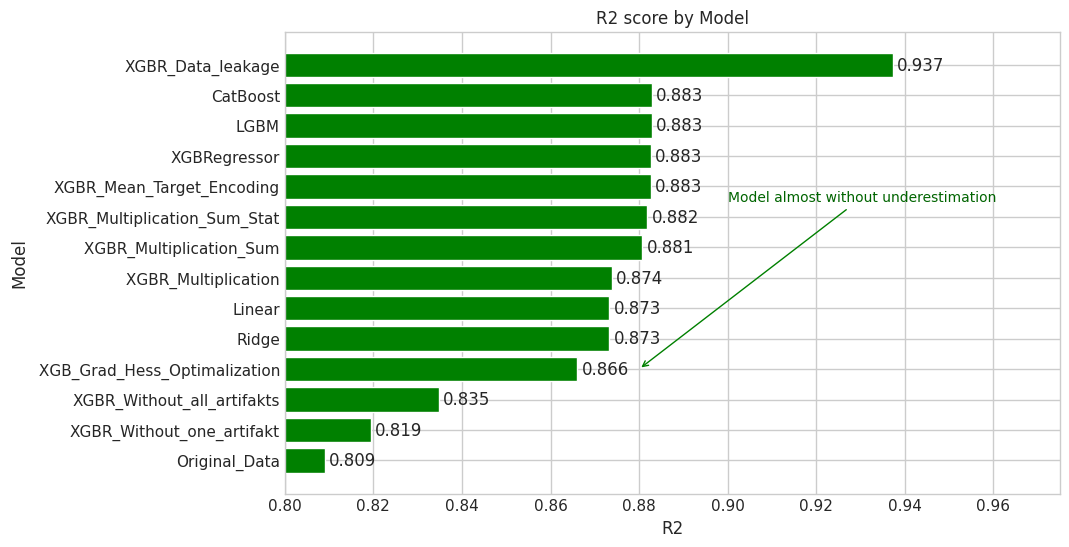

In [129]:
df_r2 = pd.DataFrame.from_dict(r2_avg, orient='index')
df_r2_sorted = df_r2.sort_values(by='avg_r2', ascending=False)

plt.figure(figsize=(10, 6))

bars = plt.barh(df_r2_sorted.index, df_r2_sorted['avg_r2'], color='green')

for bar in bars:
    plt.text(
        bar.get_width() + 0.001,  
        bar.get_y() + bar.get_height() / 2,  
        f'{bar.get_width():.3f}', 
        va='center', 
        ha='left'  
    )

plt.annotate(
    'Model almost without underestimation', 
    xy=(0.88, 10),  
    xytext=(0.90, 4.5),  
    arrowprops=dict(facecolor='green', edgecolor='green', arrowstyle='->'), 
    fontsize=10, color='darkgreen', ha='left' 
)

plt.xlabel('R2')
plt.ylabel('Model')
plt.title('R2 score by Model')
plt.gca().invert_yaxis() 
plt.xlim(0.800, 0.975) 

plt.show()

Underestimation and overestimation results summary - plots.

In [130]:
df_u = pd.DataFrame.from_dict(underestimation, orient='index')
df_o = pd.DataFrame.from_dict(overestimation, orient='index')

In [131]:
df_u_sorted = df_u.sort_values(by='percent_underestimated', ascending=False)
df_o_sorted = df_o.sort_values(by='percent_overestimated', ascending=False)

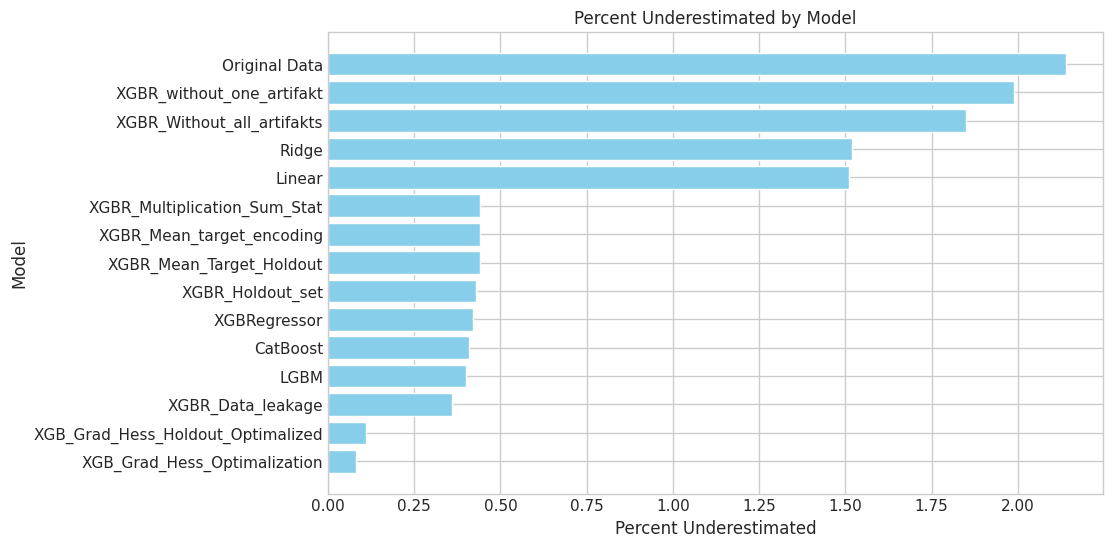

In [132]:
plt.figure(figsize=(10, 6))
plt.barh(df_u_sorted.index, df_u_sorted['percent_underestimated'], color='skyblue')
plt.xlabel('Percent Underestimated')
plt.ylabel('Model')
plt.title('Percent Underestimated by Model')
plt.gca().invert_yaxis() 
plt.show()

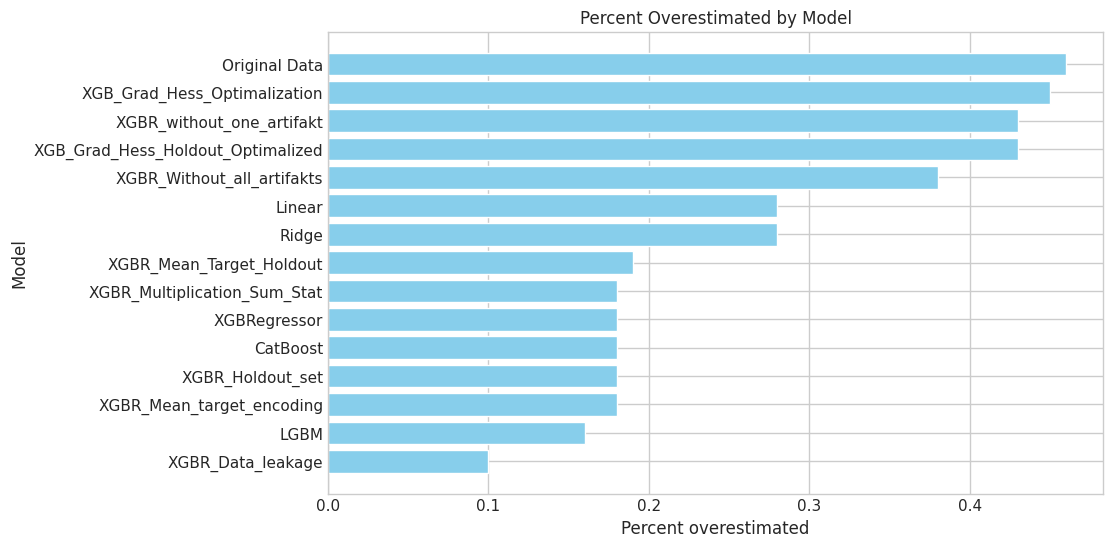

In [133]:
plt.figure(figsize=(10, 6))
plt.barh(df_o_sorted.index, df_o_sorted['percent_overestimated'], color='skyblue')
plt.xlabel('Percent overestimated')
plt.ylabel('Model')
plt.title('Percent Overestimated by Model')
plt.gca().invert_yaxis() 
plt.show()

30. Submission.

In [134]:
target_col = "FloodProbability"
test[target_col] = test_pred

In [135]:
submission = test[["id", target_col]]
submission.to_csv("submission.csv", index=False)